# Import packages

In [59]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
import json 
import re
import string

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.svm import SVC

from scipy.spatial.distance import cdist
import shap
shap.initjs()
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import scipy.spatial.distance as distance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Load data

In [60]:
# Read the csv file
df = pd.read_csv('hotel_bookings.csv')

In [61]:
# Observe data
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [62]:
# Ratio of the target variable
df['is_canceled'].sum()/df['is_canceled'].shape[0]

0.37041628277075134

In [63]:
# Shape and Columns
print('Shape:',df.shape)
print('Columns:',df.columns)

Shape: (119390, 32)
Columns: Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


In [64]:
# Descriptive statistics
df.describe().T

count         mean         std      min  \
is_canceled                     119390.0     0.370416    0.482918     0.00   
lead_time                       119390.0   104.011416  106.863097     0.00   
arrival_date_year               119390.0  2016.156554    0.707476  2015.00   
arrival_date_week_number        119390.0    27.165173   13.605138     1.00   
arrival_date_day_of_month       119390.0    15.798241    8.780829     1.00   
stays_in_weekend_nights         119390.0     0.927599    0.998613     0.00   
stays_in_week_nights            119390.0     2.500302    1.908286     0.00   
adults                          119390.0     1.856403    0.579261     0.00   
children                        119386.0     0.103890    0.398561     0.00   
babies                          119390.0     0.007949    0.097436     0.00   
is_repeated_guest               119390.0     0.031912    0.175767     0.00   
previous_cancellations          119390.0     0.087118    0.844336     0.00   
previous_bookings_not_canceled  119390.0     0.137097    1.497437     0.00   
booking_changes                 119390.0     0.221124    0.652306     0.00   
agent                           103050.0    86.693382  110.774548     1.00   
company                           6797.0   189.266735  131.655015     6.00   
days_in_waiting_list            119390.0     2.321149   17.594721     0.00   
adr                             119390.0   101.831122   50.535790    -6.38   
required_car_parking_spaces     119390.0     0.062518    0.245291     0.00   
total_of_special_requests       119390.0     0.571363    0.792798     0.00   

                                    25%       50%     75%     max  
is_canceled                        0.00     0.000     1.0     1.0  
lead_time                         18.00    69.000   160.0   737.0  
arrival_date_year               2016.00  2016.000  2017.0  2017.0  
arrival_date_week_number          16.00    28.000    38.0    53.0  
arrival_date_day_of_month          8.00    16.000    23.0    31.0  
stays_in_weekend_nights            0.00     1.000     2.0    19.0  
stays_in_week_nights               1.00     2.000     3.0    50.0  
adults                             2.00     2.000     2.0    55.0  
children                           0.00     0.000     0.0    10.0  
babies                             0.00     0.000     0.0    10.0  
is_repeated_guest                  0.00     0.000     0.0     1.0  
previous_cancellations             0.00     0.000     0.0    26.0  
previous_bookings_not_canceled     0.00     0.000     0.0    72.0  
booking_changes                    0.00     0.000     0.0    21.0  
agent                              9.00    14.000   229.0   535.0  
company                           62.00   179.000   270.0   543.0  
days_in_waiting_list               0.00     0.000     0.0   391.0  
adr                               69.29    94.575   126.0  5400.0  
required_car_parking_spaces        0.00     0.000     0.0     8.0  
total_of_special_requests          0.00     0.000     1.0     5.0

In [65]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Data Preprocessing

## Data Removal

In [66]:
# Removal of data leakage columns
df = df.drop(columns=['country','assigned_room_type','days_in_waiting_list','reservation_status','reservation_status_date'])

## Missing Data Analysis

In [67]:
# Count the number of missing values for each feature
missing_values = df.isnull().sum()

# Calculate the percentage of missing data for each feature
percentage_missing = (missing_values / len(df)) * 100

# Create a DataFrame to store the results
missing_data_info = pd.DataFrame({'Number of Missing Values': missing_values, 'Percentage': percentage_missing})

# Sort the DataFrame by percentage missing in descending order
missing_data_info = missing_data_info.sort_values(by='Percentage', ascending=False)

missing_data_info

Number of Missing Values  Percentage
company                                           112593   94.306893
agent                                              16340   13.686238
children                                               4    0.003350
hotel                                                  0    0.000000
distribution_channel                                   0    0.000000
required_car_parking_spaces                            0    0.000000
adr                                                    0    0.000000
customer_type                                          0    0.000000
deposit_type                                           0    0.000000
booking_changes                                        0    0.000000
reserved_room_type                                     0    0.000000
previous_bookings_not_canceled                         0    0.000000
previous_cancellations                                 0    0.000000
is_repeated_guest                                      0    0.000000
market_segment                                         0    0.000000
is_canceled                                            0    0.000000
meal                                                   0    0.000000
babies                                                 0    0.000000
adults                                                 0    0.000000
stays_in_week_nights                                   0    0.000000
stays_in_weekend_nights                                0    0.000000
arrival_date_day_of_month                              0    0.000000
arrival_date_week_number                               0    0.000000
arrival_date_month                                     0    0.000000
arrival_date_year                                      0    0.000000
lead_time                                              0    0.000000
total_of_special_requests                              0    0.000000

In [68]:
# Missing data imputation
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# Drop missing values of children
df = df.dropna()
df

hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July                        27   
3                    July                        27   
4                    July                        27   
...                   ...                       ...   
119385             August                        35   
119386             August                        35   
119387             August                        35   
119388             August                        35   
119389             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
0                               1                        0   
1                               1                        0   
2                               1                        0   
3                               1                        0   
4                               1                        0   
...                           ...                      ...   
119385                         30                        2   
119386                         31                        2   
119387                         31                        2   
119388                         31                        2   
119389                         29                        2   

        stays_in_week_nights  adults  ...  previous_bookings_not_canceled  \
0                          0       2  ...                               0   
1                          0       2  ...                               0   
2                          1       1  ...                               0   
3                          1       1  ...                               0   
4                          2       2  ...                               0   
...                      ...     ...  ...                             ...   
119385                     5       2  ...                               0   
119386                     5       3  ...                               0   
119387                     5       2  ...                               0   
119388                     5       2  ...                               0   
119389                     7       2  ...                               0   

        reserved_room_type booking_changes deposit_type  agent  company  \
0                        C               3   No Deposit    0.0      0.0   
1                        C               4   No Deposit    0.0      0.0   
2                        A               0   No Deposit    0.0      0.0   
3                        A               0   No Deposit  304.0      0.0   
4                        A               0   No Deposit  240.0      0.0   
...                    ...             ...          ...    ...      ...   
119385                   A               0   No Deposit  394.0      0.0   
119386                   E               0   No Deposit    9.0      0.0   
119387                   D               0   No Deposit    9.0      0.0   
119388                   A               0   No Deposit   89.0      0.0   
119389                   A               0   No Deposi

## Outlier Analysis

In [69]:
# Outlier analysis
index = ['adr', 'adults', 'babies', 'arrival_date_day_of_month', 'arrival_date_week_number', 
         'arrival_date_year', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']


for i, col in enumerate(index):
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Show outliers
    print(col, df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0],round((df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0])/df.shape[0]*100,2))

adr 3793 3.18
adults 29709 24.88
babies 917 0.77
arrival_date_day_of_month 0 0.0
arrival_date_week_number 0 0.0
arrival_date_year 0 0.0
booking_changes 18076 15.14
children 8590 7.2
lead_time 3005 2.52
previous_bookings_not_canceled 3620 3.03
previous_cancellations 6484 5.43
required_car_parking_spaces 7416 6.21
stays_in_weekend_nights 265 0.22
stays_in_week_nights 3354 2.81
total_of_special_requests 2877 2.41


In [70]:
# Descriptive statistics of outliers

outlier_data = []
for col in index:
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outlier_count = df.shape[0] - df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0]
    outlier_percent = round((outlier_count / df.shape[0]) * 100, 2)
    
    # Append data to list
    outlier_data.append([col, outlier_count, outlier_percent])

# Create dataframe
outlier_df = pd.merge(pd.DataFrame(outlier_data, columns=['Feature', 'Outlier Count', 'Outlier Percentage']),df[index].describe().T.rename_axis("Feature"),on ='Feature',how='left')
outlier_df.sort_values(by = 'Outlier Percentage', ascending = False)

Feature  Outlier Count  Outlier Percentage  \
1                           adults          29709               24.88   
6                  booking_changes          18076               15.14   
7                         children           8590                7.20   
11     required_car_parking_spaces           7416                6.21   
10          previous_cancellations           6484                5.43   
9   previous_bookings_not_canceled           3620                3.03   
13            stays_in_week_nights           1438                1.20   
2                           babies            917                0.77   
0                              adr            327                0.27   
8                        lead_time            181                0.15   
12         stays_in_weekend_nights             33                0.03   
14       total_of_special_requests             40                0.03   
3        arrival_date_day_of_month              0                0.00   
4         arrival_date_week_number              0                0.00   
5                arrival_date_year              0                0.00   

       count         mean         std      min      25%      50%     75%  \
1   119386.0     1.856390    0.579261     0.00     2.00     2.00     2.0   
6   119386.0     0.221131    0.652315     0.00     0.00     0.00     0.0   
7   119386.0     0.103890    0.398561     0.00     0.00     0.00     0.0   
11  119386.0     0.062520    0.245295     0.00     0.00     0.00     0.0   
10  119386.0     0.087121    0.844350     0.00     0.00     0.00     0.0   
9   119386.0     0.137102    1.497462     0.00     0.00     0.00     0.0   
13  119386.0     2.500310    1.908289     0.00     1.00     2.00     3.0   
2   119386.0     0.007949    0.097438     0.00     0.00     0.00     0.0   
0   119386.0   101.833541   50.534664    -6.38    69.29    94.59   126.0   
8   119386.0   104.014801  106.863286     0.00    18.00    69.00   160.0   
12  119386.0     0.927605    0.998618     0.00     0.00     1.00     2.0   
14  119386.0     0.571340    0.792798     0.00     0.00     0.00     1.0   
3   119386.0    15.798553    8.780783     1.00     8.00    16.00    23.0   
4   119386.0    27.165003   13.605334     1.00    16.00    28.00    38.0   
5   119386.0  2016.156593    0.707456  2015.00  2016.00  2016.00  2017.0   

       max  
1     55.0  
6     21.0  
7     10.0  
11     8.0  
10    26.0  
9     72.0  
13    50.0  
2     10.0  
0   5400.0  
8    737.0  
12    19.0  
14     5.0  
3     31.0  
4     53.0  
5   2017.0

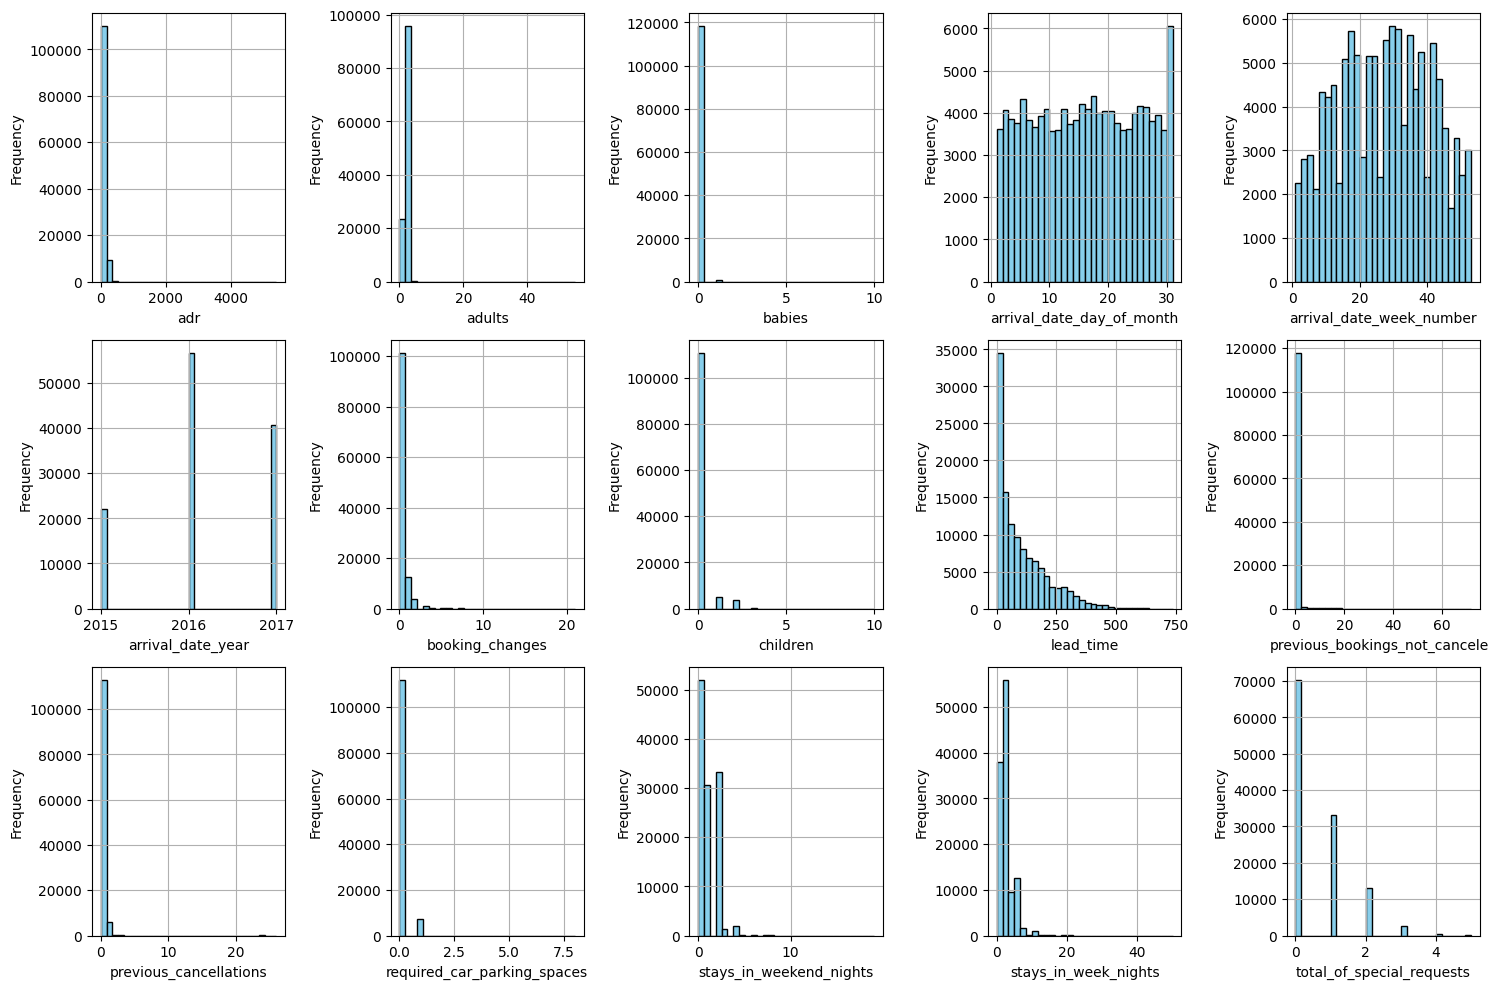

In [71]:
# Calculate number of columns and rows required
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create histograms for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Hide empty subplots
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

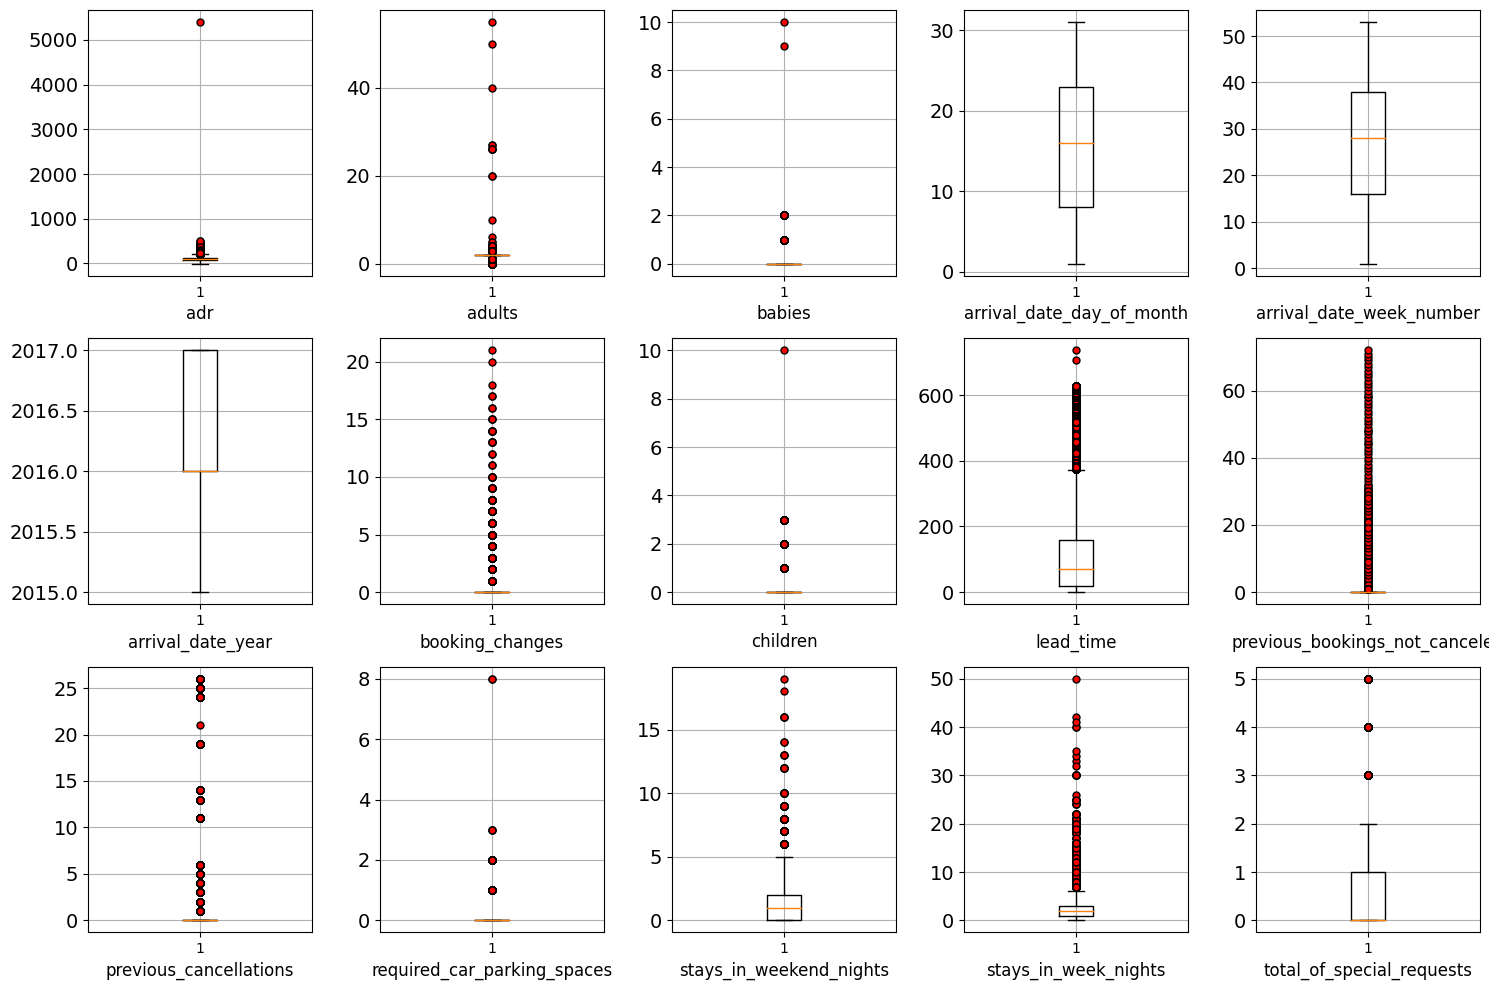

In [72]:
# Number of rows and columns
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create boxplots for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.boxplot(df[column], vert=True, flierprops=dict(marker='o', markersize=5, linestyle='none', markerfacecolor='red'))
    ax.set_xlabel(column, fontsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

# Hide empty subplots if any
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [73]:
# Define a dictionary mapping month names to numerical values
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month names to numerical values
df['arrival_date_month'] = df['arrival_date_month'].map(month_map)

# Create date
df['dateInt']=df['arrival_date_year'].astype(str) + df['arrival_date_month'].astype(str).str.zfill(2)+ df['arrival_date_day_of_month'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d')
df = df.drop(columns=['dateInt'])

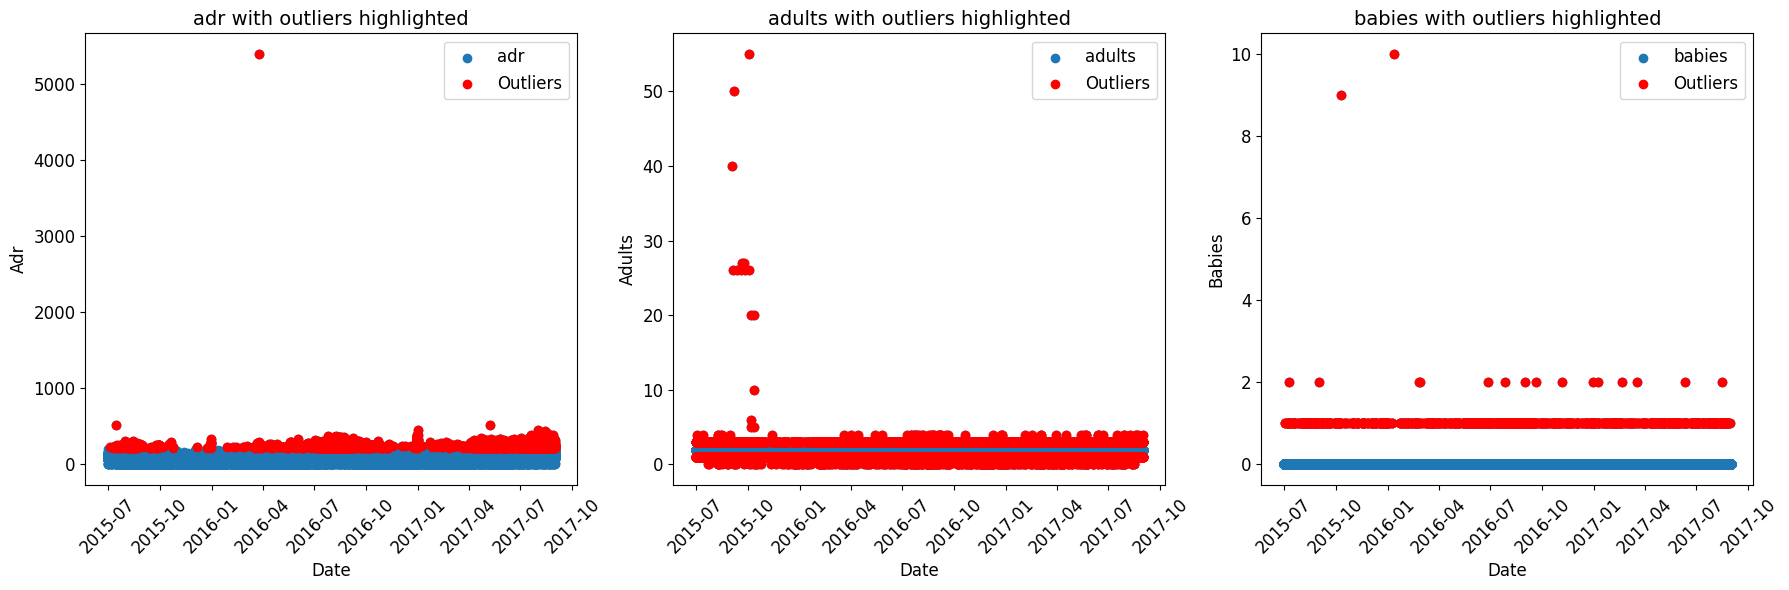

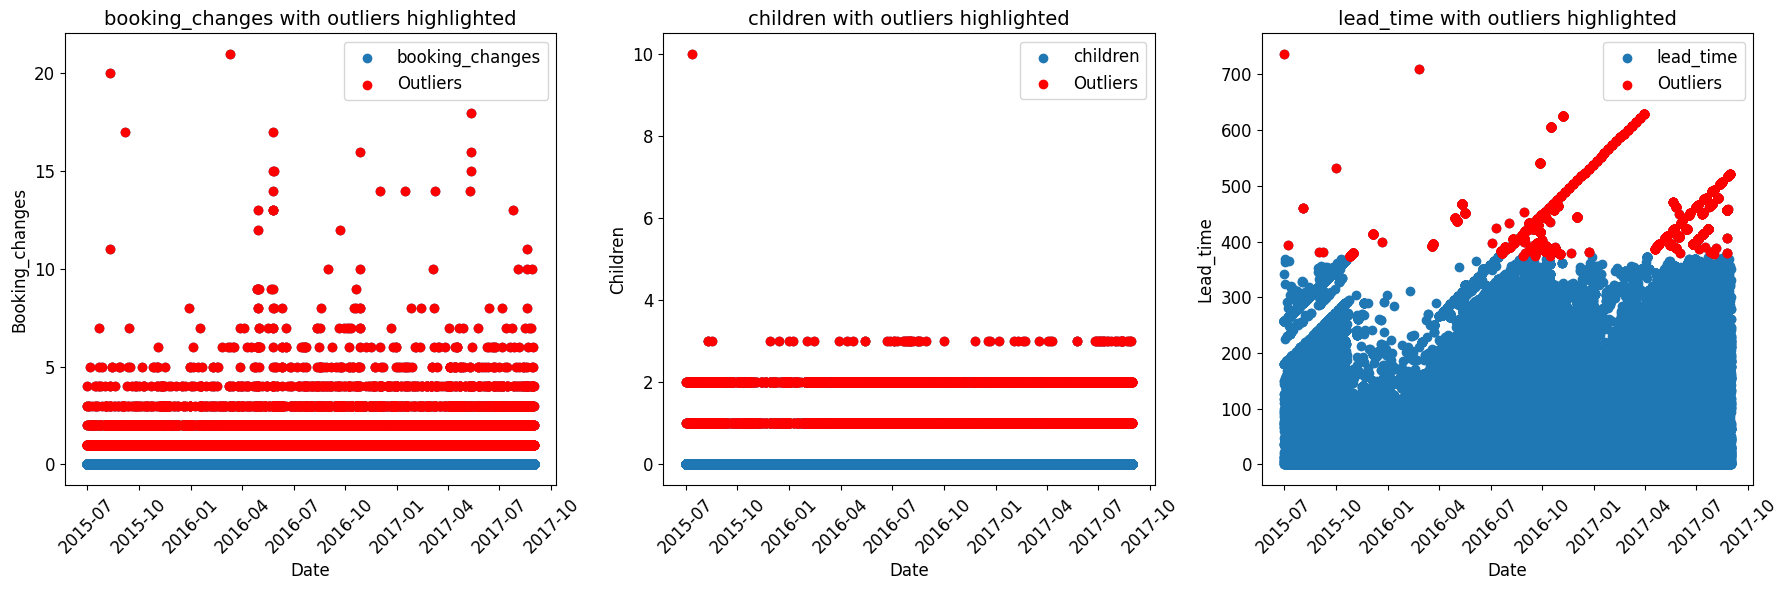

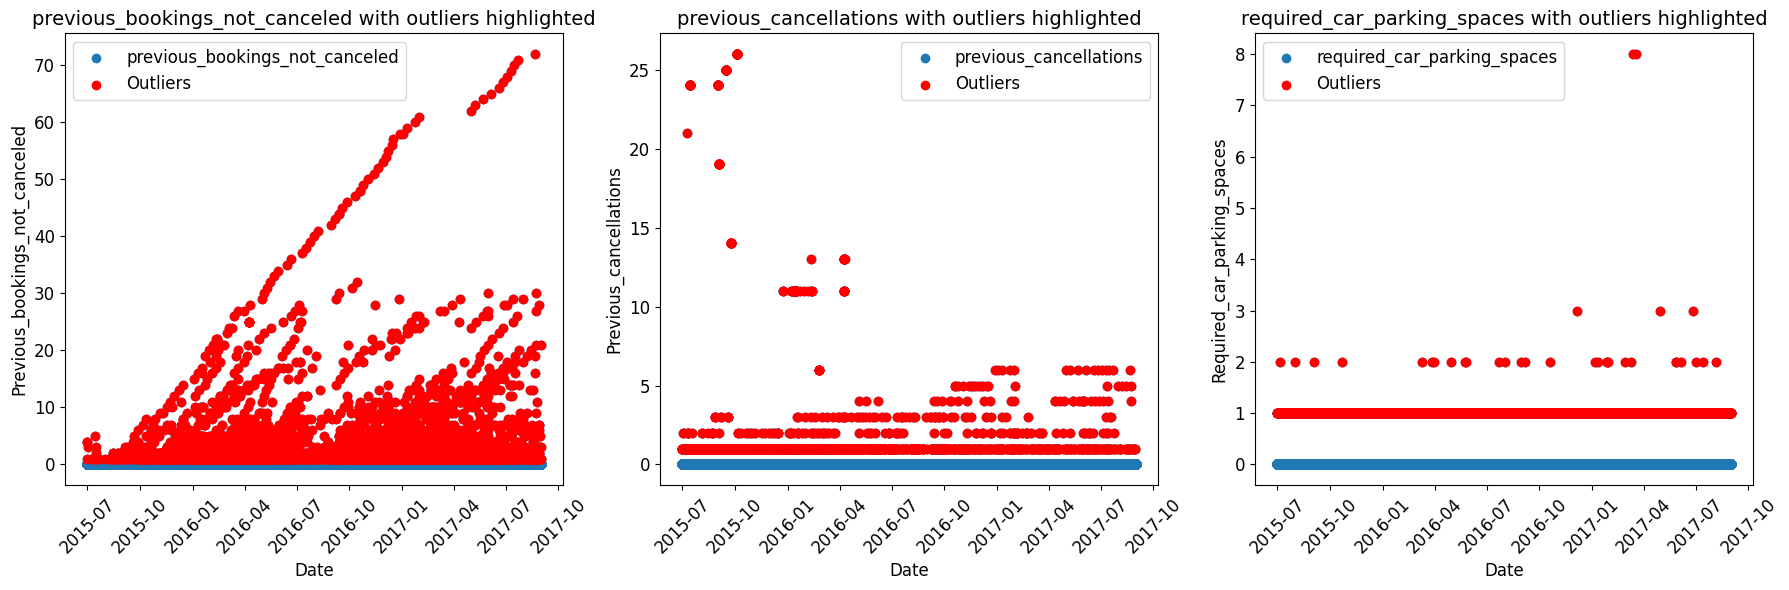

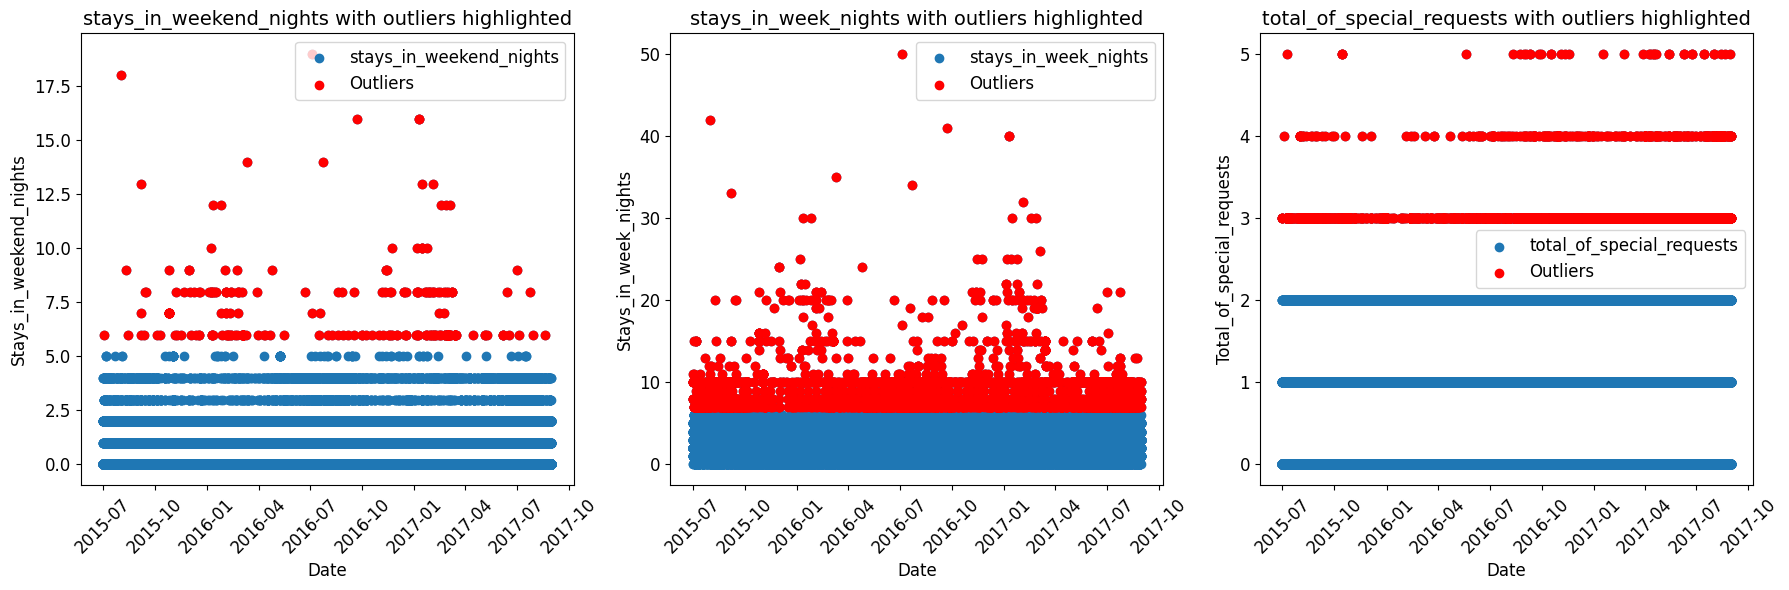

In [74]:
index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows needed
num_rows = int(np.ceil(len(index) / 3))

# Iterate through the indices and create plots
for i in range(num_rows):
    # Create a subplot with three columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each index in the current row
    for j in range(3):
        idx = i * 3 + j
        if idx < len(index):
            col = index[idx]
            # Calculate outliers
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

            # Plotting
            axes[j].scatter(df['date'], df[col], label=col)
            axes[j].scatter(outliers['date'], outliers[col], color='red', label='Outliers')

            # Formatting
            axes[j].set_title(f'{col} with outliers highlighted', fontsize=14)
            axes[j].set_xlabel('Date',fontsize=12)
            axes[j].set_ylabel(col.capitalize(),fontsize=12)
            axes[j].tick_params(axis='x', labelsize=12,rotation=45)  # Set x-axis tick label fontsize
            axes[j].tick_params(axis='y', labelsize=12)  # Set y-axis tick label fontsize
            axes[j].legend(fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [75]:
# Remove outliers
df = df[df['adr'] <5000]

# Data Splitting

In [76]:
## Split the data for training and testing
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=42)

In [77]:
X_train.head()

hotel  lead_time  arrival_date_year  arrival_date_month  \
91766     City Hotel        133               2016                   6   
57469     City Hotel        418               2016                   9   
104492    City Hotel          9               2017                   1   
19580   Resort Hotel          0               2015                  12   
110266    City Hotel         26               2017                   4   

        arrival_date_week_number  arrival_date_day_of_month  \
91766                         26                         21   
57469                         40                         26   
104492                         2                          9   
19580                         52                         26   
110266                        16                         22   

        stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
91766                         0                     5       2       0.0  ...   
57469                         1                     2       2       0.0  ...   
104492                        1                     5       2       0.0  ...   
19580                         1                     1       2       0.0  ...   
110266                        2                     1       3       0.0  ...   

        reserved_room_type booking_changes deposit_type  agent  company  \
91766                    D               0   No Deposit   85.0      0.0   
57469                    A               0   No Deposit  132.0      0.0   
104492                   A               0   No Deposit    7.0      0.0   
19580                    D               0   No Deposit  240.0      0.0   
110266                   E               0   No Deposit    9.0      0.0   

          customer_type     adr required_car_parking_spaces  \
91766   Transient-Party   90.95                           0   
57469   Transient-Party  107.00                           0   
104492        Transient   60.63                           0   
19580         Transient   71.00                           1   
110266        Transient  214.00                           0   

        total_of_special_requests       date  
91766                           0 2016-06-21  
57469                           0 2016-09-26  
104492                          1 2017-01-09  
19580                           0 2015-12-26  
110266                          2 2017-04-22  

[5 rows x 27 columns]

In [78]:
X_test.head()

hotel  lead_time  arrival_date_year  arrival_date_month  \
21971   Resort Hotel          0               2016                   3   
109247    City Hotel         89               2017                   4   
113048    City Hotel         20               2017                   5   
25221   Resort Hotel        130               2016                   6   
31064   Resort Hotel          0               2017                   1   

        arrival_date_week_number  arrival_date_day_of_month  \
21971                         12                         14   
109247                        14                          6   
113048                        22                         30   
25221                         25                         12   
31064                          4                         23   

        stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
21971                         0                     0       1       0.0  ...   
109247                        0                     3       2       0.0  ...   
113048                        0                     3       2       0.0  ...   
25221                         2                     5       2       2.0  ...   
31064                         1                     1       1       0.0  ...   

        reserved_room_type booking_changes deposit_type  agent  company  \
21971                    A               0   No Deposit  196.0      0.0   
109247                   D               0   No Deposit    9.0      0.0   
113048                   A               0   No Deposit    9.0      0.0   
25221                    G               0   No Deposit  240.0      0.0   
31064                    A               1   No Deposit    0.0      0.0   

          customer_type     adr required_car_parking_spaces  \
21971         Transient    0.00                           0   
109247        Transient  139.50                           1   
113048  Transient-Party  133.33                           0   
25221         Transient  161.00                           0   
31064         Transient   40.00                           0   

        total_of_special_requests       date  
21971                           0 2016-03-14  
109247                          1 2017-04-06  
113048                          1 2017-05-30  
25221                           1 2016-06-12  
31064                           0 2017-01-23  

[5 rows x 27 columns]

# Feature Enginnering

In [79]:
# Training set

# Sum two columns
X_train['sum_of_weekend_nights_and_week_nights'] = X_train['stays_in_weekend_nights'] + X_train['stays_in_week_nights'] 

# Multiply two columns
X_train['interaction_nights_and_adr'] = X_train['sum_of_weekend_nights_and_week_nights'] * X_train['adr']  

X_train.head()

hotel  lead_time  arrival_date_year  arrival_date_month  \
91766     City Hotel        133               2016                   6   
57469     City Hotel        418               2016                   9   
104492    City Hotel          9               2017                   1   
19580   Resort Hotel          0               2015                  12   
110266    City Hotel         26               2017                   4   

        arrival_date_week_number  arrival_date_day_of_month  \
91766                         26                         21   
57469                         40                         26   
104492                         2                          9   
19580                         52                         26   
110266                        16                         22   

        stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
91766                         0                     5       2       0.0  ...   
57469                         1                     2       2       0.0  ...   
104492                        1                     5       2       0.0  ...   
19580                         1                     1       2       0.0  ...   
110266                        2                     1       3       0.0  ...   

        deposit_type  agent company    customer_type     adr  \
91766     No Deposit   85.0     0.0  Transient-Party   90.95   
57469     No Deposit  132.0     0.0  Transient-Party  107.00   
104492    No Deposit    7.0     0.0        Transient   60.63   
19580     No Deposit  240.0     0.0        Transient   71.00   
110266    No Deposit    9.0     0.0        Transient  214.00   

        required_car_parking_spaces  total_of_special_requests       date  \
91766                             0                          0 2016-06-21   
57469                             0                          0 2016-09-26   
104492                            0                          1 2017-01-09   
19580                             1                          0 2015-12-26   
110266                            0                          2 2017-04-22   

        sum_of_weekend_nights_and_week_nights interaction_nights_and_adr  
91766                                       5                     454.75  
57469                                       3                     321.00  
104492                                      6                     363.78  
19580                                       2                     142.00  
110266                                      3                     642.00  

[5 rows x 29 columns]

In [80]:
# Testing set

# Sum two columns
X_test['sum_of_weekend_nights_and_week_nights'] = X_test['stays_in_weekend_nights'] + X_test['stays_in_week_nights']

# Multiply two columns
X_test['interaction_nights_and_adr'] = X_test['sum_of_weekend_nights_and_week_nights'] * X_test['adr']  

X_test.head()

hotel  lead_time  arrival_date_year  arrival_date_month  \
21971   Resort Hotel          0               2016                   3   
109247    City Hotel         89               2017                   4   
113048    City Hotel         20               2017                   5   
25221   Resort Hotel        130               2016                   6   
31064   Resort Hotel          0               2017                   1   

        arrival_date_week_number  arrival_date_day_of_month  \
21971                         12                         14   
109247                        14                          6   
113048                        22                         30   
25221                         25                         12   
31064                          4                         23   

        stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
21971                         0                     0       1       0.0  ...   
109247                        0                     3       2       0.0  ...   
113048                        0                     3       2       0.0  ...   
25221                         2                     5       2       2.0  ...   
31064                         1                     1       1       0.0  ...   

        deposit_type  agent company    customer_type     adr  \
21971     No Deposit  196.0     0.0        Transient    0.00   
109247    No Deposit    9.0     0.0        Transient  139.50   
113048    No Deposit    9.0     0.0  Transient-Party  133.33   
25221     No Deposit  240.0     0.0        Transient  161.00   
31064     No Deposit    0.0     0.0        Transient   40.00   

        required_car_parking_spaces  total_of_special_requests       date  \
21971                             0                          0 2016-03-14   
109247                            1                          1 2017-04-06   
113048                            0                          1 2017-05-30   
25221                             0                          1 2016-06-12   
31064                             0                          0 2017-01-23   

        sum_of_weekend_nights_and_week_nights interaction_nights_and_adr  
21971                                       0                       0.00  
109247                                      3                     418.50  
113048                                      3                     399.99  
25221                                       7                    1127.00  
31064                                       2                      80.00  

[5 rows x 29 columns]

# Feature Encoding and Scaling

In [81]:
# Standardization and one-hot encoding
featurizer = ColumnTransformer(
        transformers=[
            ("hotel", OneHotEncoder(handle_unknown='ignore', sparse=False), ["hotel"]),
            ("lead_time", StandardScaler(), ["lead_time"]),
            ("arrival_date_year", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_year"]),
            ("arrival_date_month", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_month"]),
            ("arrival_date_day_of_month", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_day_of_month"]),
            ("arrival_date_week_number", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_week_number"]),
            ("stays_in_weekend_nights",  StandardScaler(), ["stays_in_weekend_nights"]),
            ("stays_in_week_nights",  StandardScaler(), ["stays_in_week_nights"]),
            ("adults", StandardScaler(), ["adults"]),
            ("children", StandardScaler(), ["children"]),
            ("babies", StandardScaler(), ["babies"]),
            ("meal", OneHotEncoder(handle_unknown='ignore', sparse=False), ["meal"]),
            ("market_segment", OneHotEncoder(handle_unknown='ignore', sparse=False), ["market_segment"]),
            ("distribution_channel", OneHotEncoder(handle_unknown='ignore', sparse=False), ["distribution_channel"]),
            ("is_repeated_guest", OneHotEncoder(handle_unknown='ignore', sparse=False), ["is_repeated_guest"]),
            ("previous_cancellations", StandardScaler(), ["previous_cancellations"]),
            ("previous_bookings_not_canceled", StandardScaler(), ["previous_bookings_not_canceled"]),
            ("reserved_room_type", OneHotEncoder(handle_unknown='ignore', sparse=False), ["reserved_room_type"]),
            ("booking_changes", StandardScaler(), ["booking_changes"]),
            ("deposit_type", OneHotEncoder(handle_unknown='ignore', sparse=False), ["deposit_type"]),
            ("agent", OneHotEncoder(handle_unknown='ignore', sparse=False), ["agent"]),
            ("company", OneHotEncoder(handle_unknown='ignore', sparse=False), ["company"]),
            ("customer_type", OneHotEncoder(handle_unknown='ignore', sparse=False), ["customer_type"]),
            ("adr", StandardScaler(), ["adr"]),
            ("required_car_parking_spaces", StandardScaler(), ["required_car_parking_spaces"]),
            ("total_of_special_requests", StandardScaler(), ["total_of_special_requests"]),
            ("sum_of_weekend_nights_and_week_nights", StandardScaler(), ["sum_of_weekend_nights_and_week_nights"]),
            ("interaction_nights_and_adr", StandardScaler(), ["interaction_nights_and_adr"])
        ],
    remainder='drop')

# Train
transformed_train = featurizer.fit_transform(X_train)
df_train = pd.DataFrame(transformed_train, columns=featurizer.get_feature_names_out())

# Test
transformed_test = featurizer.transform(X_test)
df_test = pd.DataFrame(transformed_test, columns=featurizer.get_feature_names_out())

In [82]:
# Train
df_train.shape

(89538, 808)

In [83]:
# Test
df_test.shape

(29847, 808)

In [84]:
# Function to rename columns
def rename_columns(df):
    renamed_columns = []
    for col in df.columns:
        if '__' in col:
            # Split the column name by '__' and take the second part
            new_col_name = col.split('__')[1]
            renamed_columns.append(new_col_name)
        else:
            renamed_columns.append(col)
    return renamed_columns

# Rename columns in training data
df_train.columns = rename_columns(df_train)

# Rename columns in testing data
df_test.columns = rename_columns(df_test)

In [85]:
df_train.head()

hotel_City Hotel  hotel_Resort Hotel  lead_time  arrival_date_year_2015  \
0               1.0                 0.0   0.274288                     0.0   
1               1.0                 0.0   2.943056                     0.0   
2               1.0                 0.0  -0.886860                     0.0   
3               0.0                 1.0  -0.971137                     1.0   
4               1.0                 0.0  -0.727671                     0.0   

   arrival_date_year_2016  arrival_date_year_2017  arrival_date_month_1  \
0                     1.0                     0.0                   0.0   
1                     1.0                     0.0                   0.0   
2                     0.0                     1.0                   1.0   
3                     0.0                     0.0                   0.0   
4                     0.0                     1.0                   0.0   

   arrival_date_month_2  arrival_date_month_3  arrival_date_month_4  ...  \
0                   0.0                   0.0                   0.0  ...   
1                   0.0                   0.0                   0.0  ...   
2                   0.0                   0.0                   0.0  ...   
3                   0.0                   0.0                   0.0  ...   
4                   0.0                   0.0                   1.0  ...   

   company_543.0  customer_type_Contract  customer_type_Group  \
0            0.0                     0.0                  0.0   
1            0.0                     0.0                  0.0   
2            0.0                     0.0                  0.0   
3            0.0                     0.0                  0.0   
4            0.0                     0.0                  0.0   

   customer_type_Transient  customer_type_Transient-Party       adr  \
0                      0.0                            1.0 -0.224018   
1                      0.0                            1.0  0.110259   
2                      1.0                            0.0 -0.855500   
3                      1.0                            0.0 -0.639521   
4                      1.0                            0.0  2.338774   

   required_car_parking_spaces  total_of_special_requests  \
0                    -0.253724                  -0.719145   
1                    -0.253724                  -0.719145   
2                    -0.253724                   0.541591   
3                     3.853661                  -0.719145   
4                    -0.253724                   1.802327   

   sum_of_weekend_nights_and_week_nights  interaction_nights_and_adr  
0                               0.615444                    0.290448  
1                              -0.165958                   -0.107997  
2                               1.006145                    0.019446  
3                              -0.556659                   -0.641242  
4                              -0.165958                    0.848270  

[5 rows x 808 columns]

In [86]:
df_test.head()

hotel_City Hotel  hotel_Resort Hotel  lead_time  arrival_date_year_2015  \
0               0.0                 1.0  -0.971137                     0.0   
1               1.0                 0.0  -0.137732                     0.0   
2               1.0                 0.0  -0.783855                     0.0   
3               0.0                 1.0   0.246196                     0.0   
4               0.0                 1.0  -0.971137                     0.0   

   arrival_date_year_2016  arrival_date_year_2017  arrival_date_month_1  \
0                     1.0                     0.0                   0.0   
1                     0.0                     1.0                   0.0   
2                     0.0                     1.0                   0.0   
3                     1.0                     0.0                   0.0   
4                     0.0                     1.0                   1.0   

   arrival_date_month_2  arrival_date_month_3  arrival_date_month_4  ...  \
0                   0.0                   1.0                   0.0  ...   
1                   0.0                   0.0                   1.0  ...   
2                   0.0                   0.0                   0.0  ...   
3                   0.0                   0.0                   0.0  ...   
4                   0.0                   0.0                   0.0  ...   

   company_543.0  customer_type_Contract  customer_type_Group  \
0            0.0                     0.0                  0.0   
1            0.0                     0.0                  0.0   
2            0.0                     0.0                  0.0   
3            0.0                     0.0                  0.0   
4            0.0                     0.0                  0.0   

   customer_type_Transient  customer_type_Transient-Party       adr  \
0                      1.0                            0.0 -2.118256   
1                      1.0                            0.0  0.787145   
2                      0.0                            1.0  0.658641   
3                      1.0                            0.0  1.234930   
4                      1.0                            0.0 -1.285166   

   required_car_parking_spaces  total_of_special_requests  \
0                    -0.253724                  -0.719145   
1                     3.853661                   0.541591   
2                    -0.253724                   0.541591   
3                    -0.253724                   0.541591   
4                    -0.253724                  -0.719145   

   sum_of_weekend_nights_and_week_nights  interaction_nights_and_adr  
0                              -1.338061                   -1.064263  
1                              -0.165958                    0.182458  
2                              -0.165958                    0.127316  
3                               1.396846                    2.293095  
4                              -0.556659                   -0.825941  

[5 rows x 808 columns]

# Feature Selection

In [87]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(df_train, y_train)

# Use feature importance from the trained model for feature selection
feature_importances = rf_classifier.feature_importances_

# Use SelectFromModel to select features based on their importance
selector = SelectFromModel(rf_classifier, prefit=True)

# Transform the training and testing datasets to select the important features
X_train_selected = selector.transform(df_train)
X_test_selected = selector.transform(df_test)

# Get boolean mask indicating selected features
selected_features_mask = selector.get_support()

# Get names of all features
all_feature_names = df_train.columns

# Get names of selected features
selected_feature_names = all_feature_names[selected_features_mask]

# Create DataFrame with only selected features for training set
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

# Create DataFrame with only selected features for testing set
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

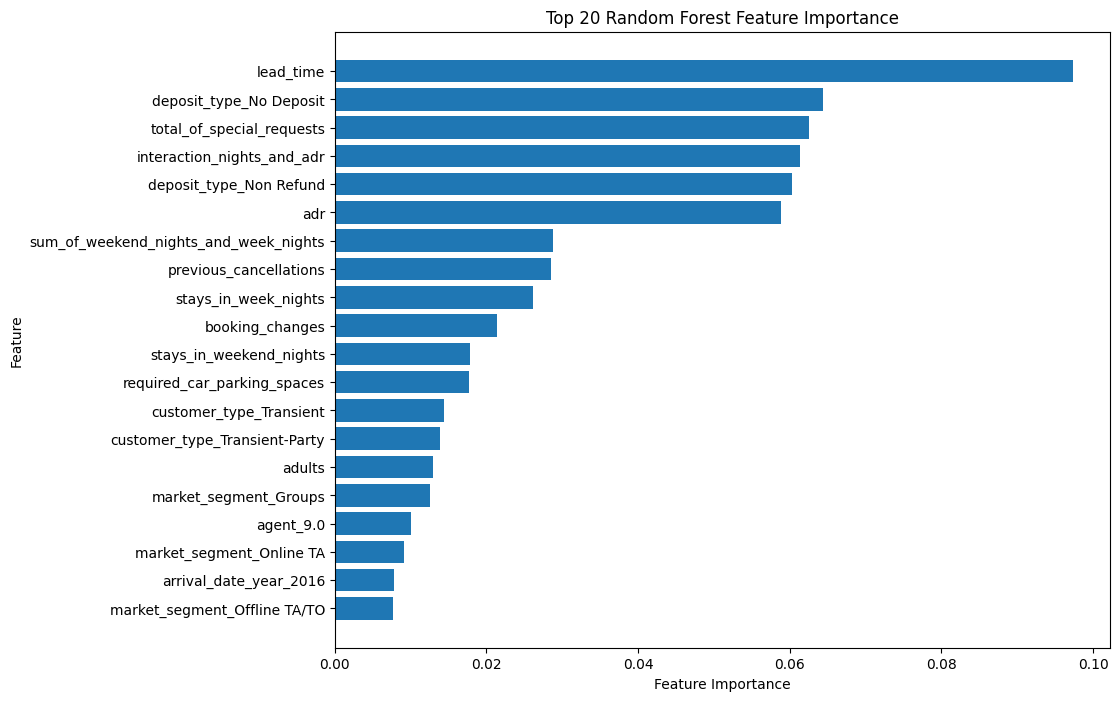

In [88]:
# Get feature names
feature_names = df_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
top_twenty_indices = sorted_indices[:20]
top_twenty_features = [feature_names[i] for i in top_twenty_indices]
top_twenty_importances = feature_importances[top_twenty_indices]

# Plot top twenty feature importances in descending order
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_twenty_importances)), top_twenty_importances, align='center')
plt.yticks(range(len(top_twenty_importances)), top_twenty_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Random Forest Feature Importance')
plt.gca().invert_yaxis() 
plt.show()


In [89]:
# Training set after feature selection
X_train_selected_df.shape

(89538, 131)

In [90]:
# Testing set after feature selection
X_test_selected_df.shape

(29847, 131)

# Data Imblance

## Without SMOTE

In [91]:
# X_train_selected_df

In [92]:
# X_test_selected_df

## With SMOTE

In [93]:
# SMOTE
smote = SMOTE(random_state=42)

In [94]:
# Resampling
X_resampled, y_resampled = smote.fit_resample(X_train_selected_df, y_train)

# Modeling & Hyperparamter Tuning

### Without SMOTE

#### Dummy

Dummy
Best Parameters: {'strategy': 'uniform'}
              precision    recall  f1-score   support

           0       0.63      0.50      0.56     18792
           1       0.37      0.50      0.43     11055

    accuracy                           0.50     29847
   macro avg       0.50      0.50      0.49     29847
weighted avg       0.53      0.50      0.51     29847

AUC: 0.5


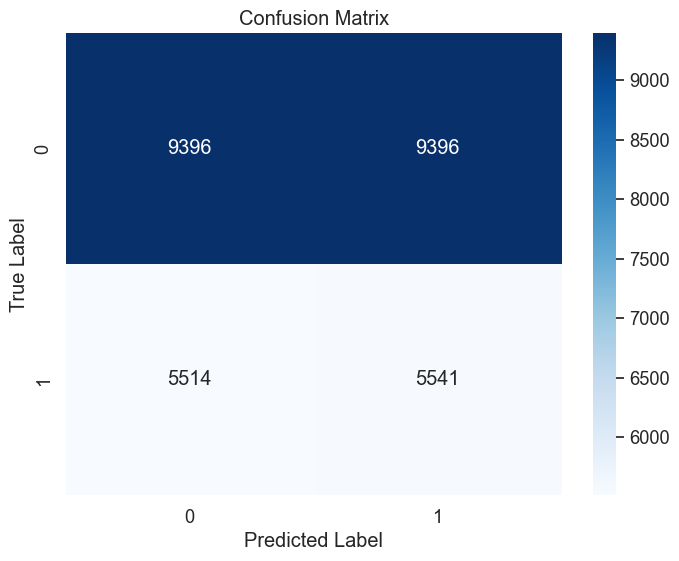

In [95]:
# Define the parameter grid to search
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'uniform', 'constant','prior']
}

dc = DummyClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dc = GridSearchCV(dc, param_grid, cv=5, scoring='f1')

# Perform the grid search
grid_search_dc.fit(X_train_selected_df, y_train)

# Get the best model
best_dummy_clf = grid_search_dc.best_estimator_

# Make predictions
y_pred = best_dummy_clf.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_dummy_clf.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('Dummy')
print("Best Parameters:", grid_search_dc.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_dummy_clf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_dummy_clf.classes_, yticklabels=best_dummy_clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RF

RF
Best Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18792
           1       0.87      0.77      0.81     11055

    accuracy                           0.87     29847
   macro avg       0.87      0.85      0.86     29847
weighted avg       0.87      0.87      0.87     29847

AUC: 0.933036761411411


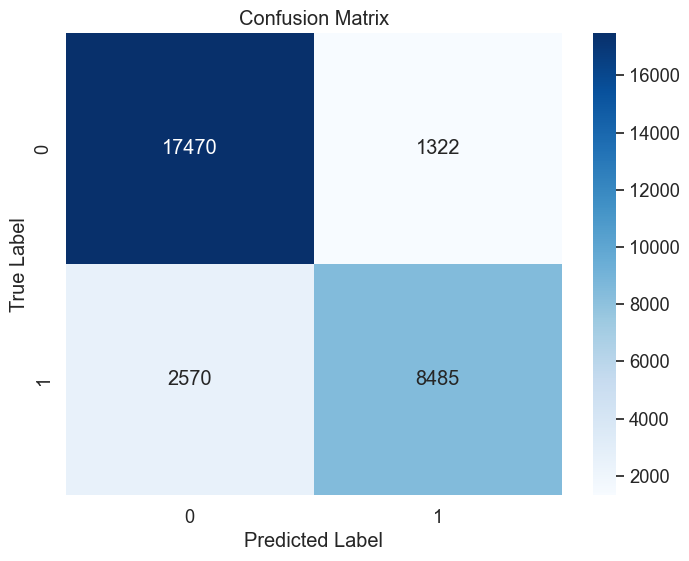

In [97]:
# Define the hyperparameters for gridsearch
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.5, None]
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the gridsearch
grid_search_rf.fit(X_train_selected_df, y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_rf.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('RF')
print("Best Parameters:", grid_search_rf.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Linear

SVM - Linear
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     18792
           1       0.81      0.64      0.72     11055

    accuracy                           0.81     29847
   macro avg       0.81      0.78      0.79     29847
weighted avg       0.81      0.81      0.81     29847

AUC: 0.8596907991679823


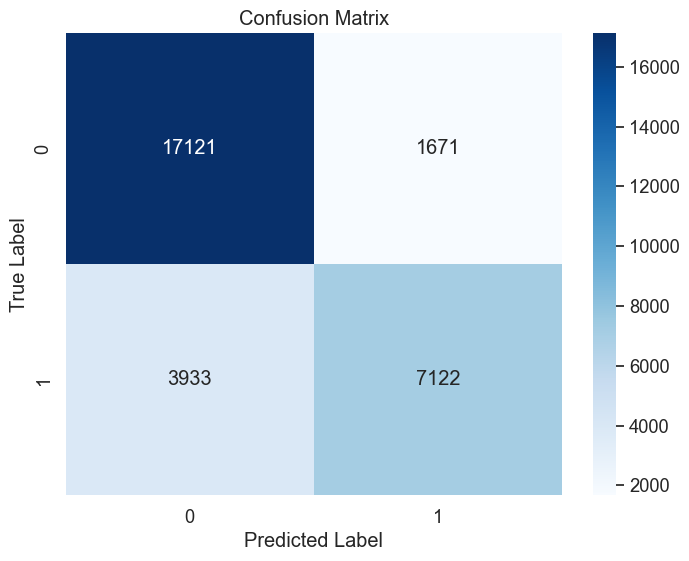

In [131]:
# Define the hyperparameters for gridsearch
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_linear = BaggingClassifier(SVC(kernel='linear', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_linear = GridSearchCV(svm_linear, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_linear.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_linear = grid_search_svm_linear.best_estimator_

# Make predictions
y_pred = best_svm_linear.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_linear.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - Linear')
print("Best Parameters:", grid_search_svm_linear.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_linear.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_linear.classes_, yticklabels=best_svm_linear.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Sigmoid

SVM - sigmoid
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     18792
           1       0.93      0.44      0.60     11055

    accuracy                           0.78     29847
   macro avg       0.84      0.71      0.72     29847
weighted avg       0.82      0.78      0.76     29847

AUC: 0.8320938676138253


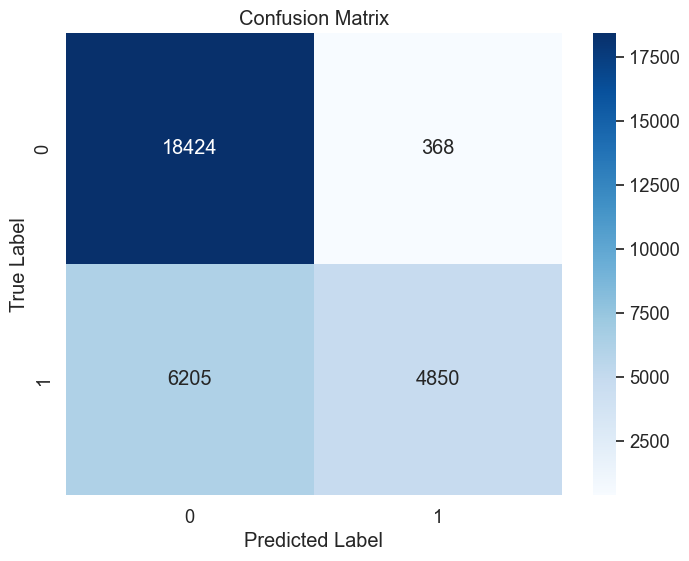

In [128]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_sigmoid = BaggingClassifier(SVC(kernel='sigmoid', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_sigmoid = GridSearchCV(svm_sigmoid, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_sigmoid.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_sigmoid = grid_search_svm_sigmoid.best_estimator_

# Make predictions
y_pred = best_svm_sigmoid.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_sigmoid.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - sigmoid')
print("Best Parameters:", grid_search_svm_sigmoid.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_sigmoid.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_sigmoid.classes_, yticklabels=best_svm_sigmoid.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - RBF

SVM - rbf
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     18792
           1       0.86      0.67      0.75     11055

    accuracy                           0.84     29847
   macro avg       0.84      0.80      0.81     29847
weighted avg       0.84      0.84      0.83     29847

AUC: 0.898753275400928


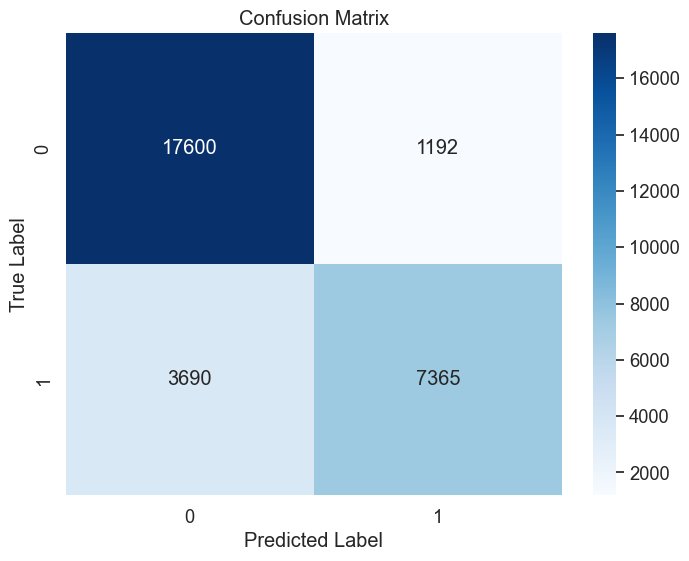

In [129]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_rbf = BaggingClassifier(SVC(kernel='rbf', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_rbf.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_rbf = grid_search_svm_rbf.best_estimator_

# Make predictions
y_pred = best_svm_rbf.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_rbf.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - rbf')
print("Best Parameters:", grid_search_svm_rbf.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_rbf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_rbf.classes_, yticklabels=best_svm_rbf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Poly

SVM - poly
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.81      0.95      0.88     18792
           1       0.88      0.63      0.73     11055

    accuracy                           0.83     29847
   macro avg       0.85      0.79      0.80     29847
weighted avg       0.84      0.83      0.82     29847

AUC: 0.8979981064336585


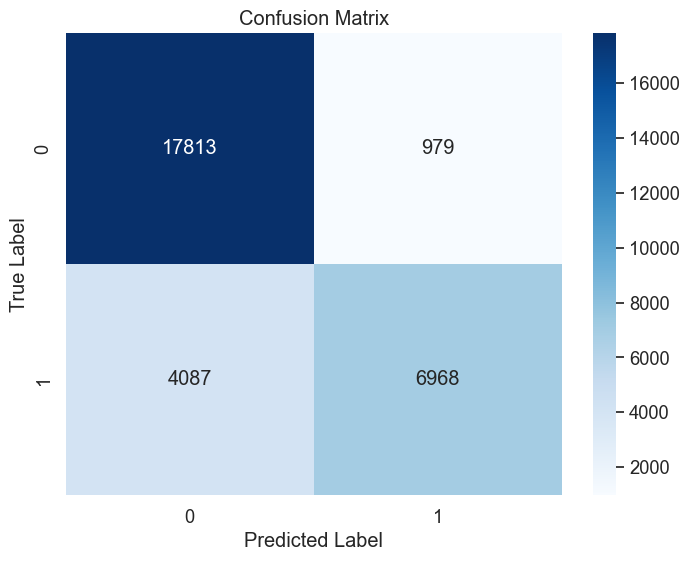

In [130]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_poly = BaggingClassifier(SVC(kernel='poly', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_poly = GridSearchCV(svm_poly, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_poly.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_poly = grid_search_svm_poly.best_estimator_

# Make predictions
y_pred = best_svm_poly.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_poly.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - poly')
print("Best Parameters:", grid_search_svm_poly.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_poly.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_poly.classes_, yticklabels=best_svm_poly.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RBFNN

In [102]:
class RadialBasisFunctionNeuralNetwork:
    def __init__(self, num_of_rbf_units=10):
        self.num_of_rbf_units = num_of_rbf_units

    def _rbf_unit(self, rbf_center, point_in_dataset):
        return np.exp(-self.beta * distance.cdist([point_in_dataset], [rbf_center], 'euclidean')**2).flatten()[0]

    def _construct_interpolation_matrix(self, input_dataset):
        interpolation_matrix = np.zeros((len(input_dataset), self.num_of_rbf_units))
        for idx, point_in_dataset in enumerate(input_dataset):
            for center_idx, rbf_center in enumerate(self.rbf_centers):
                interpolation_matrix[idx, center_idx] = self._rbf_unit(rbf_center, point_in_dataset)
        return interpolation_matrix

    def train_model(self, input_dataset, target_dataset):
        self.kmeans_clustering = KMeans(n_clusters=self.num_of_rbf_units, random_state=42).fit(input_dataset)
        self.rbf_centers = self.kmeans_clustering.cluster_centers_
        self.beta = 1.0 / (2.0 * (self.kmeans_clustering.inertia_ / input_dataset.shape[0]))
        interpolation_matrix = self._construct_interpolation_matrix(input_dataset)
        self.model_weights = np.linalg.pinv(interpolation_matrix.T.dot(interpolation_matrix)).dot(interpolation_matrix.T).dot(target_dataset)

    def predict(self, input_dataset):
        interpolation_matrix = self._construct_interpolation_matrix(input_dataset)
        predicted_values = interpolation_matrix.dot(self.model_weights)
        return predicted_values
    
def grid_search_cv(df_train, y_train, num_of_rbf_units_list, n_splits=5):
    kf = KFold(n_splits=n_splits)
    best_f1_score = 0
    best_num_of_rbf_units = None

    for num_of_rbf_units in num_of_rbf_units_list:
        f1_scores = []
        for train_index, val_index in kf.split(df_train):
            X_train_fold, X_val_fold = df_train.iloc[train_index], df_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            rbf_neural_network = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=num_of_rbf_units)
            rbf_neural_network.train_model(X_train_fold.values, y_train_fold.values)
            
            predictions = rbf_neural_network.predict(X_val_fold.values)
            binary_predictions = np.where(predictions > 0.5, 1, 0)
            f1 = f1_score(y_val_fold, binary_predictions)
            f1_scores.append(f1)

        avg_f1_score = np.mean(f1_scores)
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_num_of_rbf_units = num_of_rbf_units

    return best_num_of_rbf_units

Best number of RBF units: 5000
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     18792
           1       0.85      0.69      0.76     11055

    accuracy                           0.84     29847
   macro avg       0.84      0.81      0.82     29847
weighted avg       0.84      0.84      0.83     29847

AUC: 0.9005501032127955


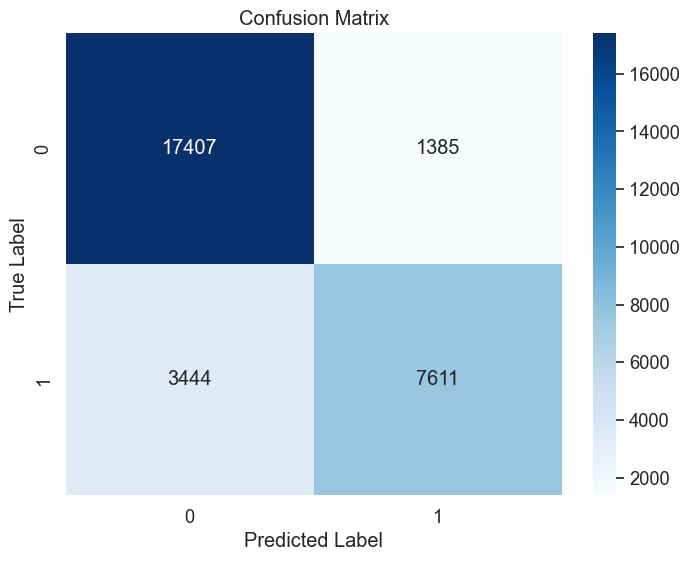

In [103]:
# Define the list of candidate values for the number of RBF units
num_of_rbf_units_list = [10, 50, 100, 300, 1000, 5000]
# Perform grid search cross-validation to find the best number of RBF units
best_num_of_rbf_units = grid_search_cv(X_train_selected_df, y_train, num_of_rbf_units_list)
print("Best number of RBF units:", best_num_of_rbf_units)
# Initialize and train the RBF neural network with the best number of RBF units
rbf_neural_network = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=best_num_of_rbf_units)
rbf_neural_network.train_model(X_train_selected_df.values, y_train.values)
# Predict the target values
predictions = rbf_neural_network.predict(X_test_selected_df.values)
# Converting continuous output to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, binary_predictions))
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
print('AUC:',roc_auc_score(y_test,predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### With SMOTE

#### Dummy

Dummy
Best Parameters: {'strategy': 'uniform'}
              precision    recall  f1-score   support

           0       0.63      0.50      0.56     18792
           1       0.37      0.50      0.43     11055

    accuracy                           0.50     29847
   macro avg       0.50      0.50      0.49     29847
weighted avg       0.53      0.50      0.51     29847

AUC: 0.5


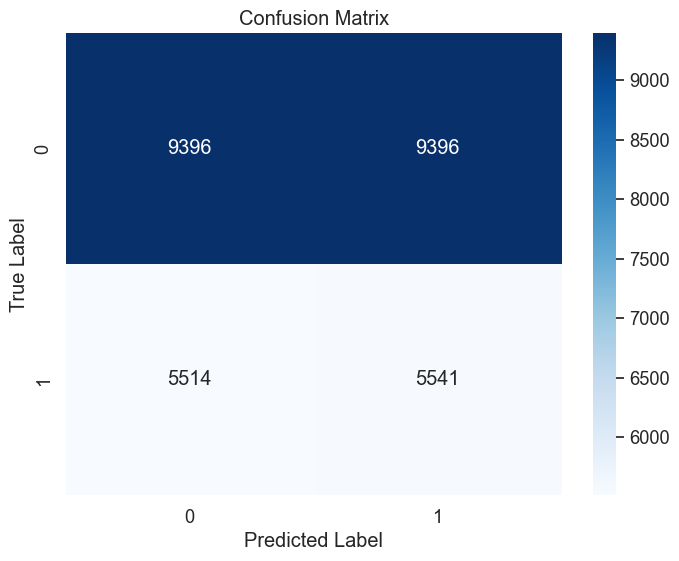

In [104]:
# Define the parameter grid to search
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'uniform', 'constant','prior']
}

dc_sm = DummyClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dc_sm = GridSearchCV(dc_sm, param_grid, cv=5, scoring='f1')

# Perform the grid search
grid_search_dc_sm.fit(X_resampled, y_resampled)

# Get the best model
best_dummy_clf_sm = grid_search_dc_sm.best_estimator_

# Make predictions
y_pred = best_dummy_clf_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_dummy_clf_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('Dummy')
print("Best Parameters:", grid_search_dc_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_dummy_clf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_dummy_clf_sm.classes_, yticklabels=best_dummy_clf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RF

RF
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     18792
           1       0.86      0.78      0.81     11055

    accuracy                           0.87     29847
   macro avg       0.87      0.85      0.86     29847
weighted avg       0.87      0.87      0.87     29847

AUC: 0.9341514687485979


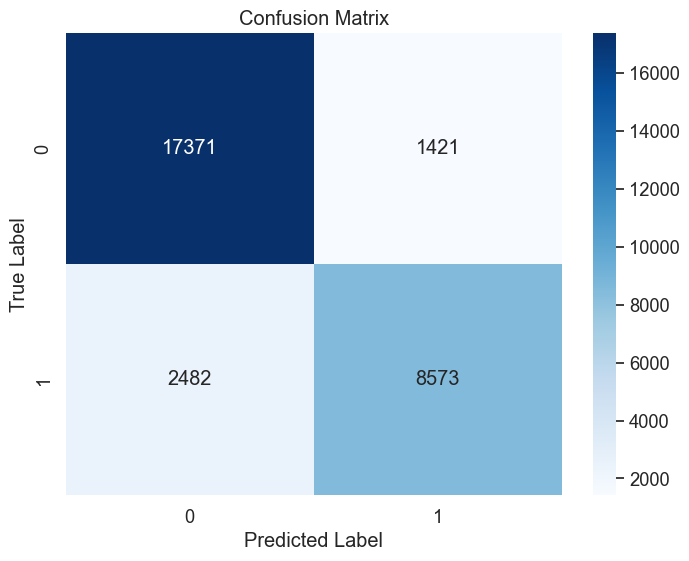

In [105]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.5, None]
}


rf_sm = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf_sm = GridSearchCV(rf_sm, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_rf_sm.fit(X_resampled, y_resampled)

# Get the best model
best_rf_sm = grid_search_rf_sm.best_estimator_

# Make predictions
y_pred = best_rf_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_rf_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('RF')
print("Best Parameters:", grid_search_rf_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_rf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf_sm.classes_, yticklabels=best_rf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Linear

SVM - Linear
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     18792
           1       0.70      0.74      0.72     11055

    accuracy                           0.78     29847
   macro avg       0.77      0.78      0.77     29847
weighted avg       0.79      0.78      0.79     29847

AUC: 0.8620764145332396


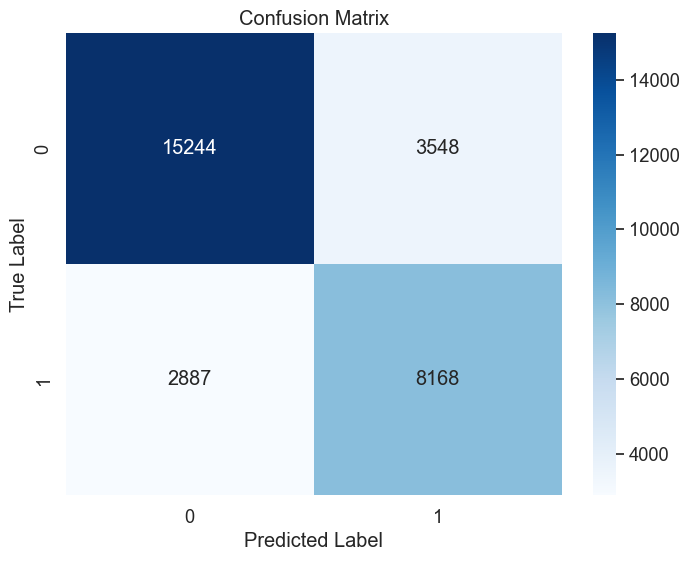

In [160]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_linear_sm = BaggingClassifier(SVC(kernel='linear', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_linear_sm = GridSearchCV(svm_linear_sm, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_svm_linear_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_linear_sm = grid_search_svm_linear_sm.best_estimator_

# Make predictions
y_pred = best_svm_linear_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_linear_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - Linear')
print("Best Parameters:", grid_search_svm_linear_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=grid_search_svm_linear_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=grid_search_svm_linear_sm.classes_, yticklabels=grid_search_svm_linear_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Sigmoid

SVM - sigmoid
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     18792
           1       0.63      0.70      0.66     11055

    accuracy                           0.73     29847
   macro avg       0.72      0.73      0.72     29847
weighted avg       0.74      0.73      0.74     29847

AUC: 0.8045989213921105


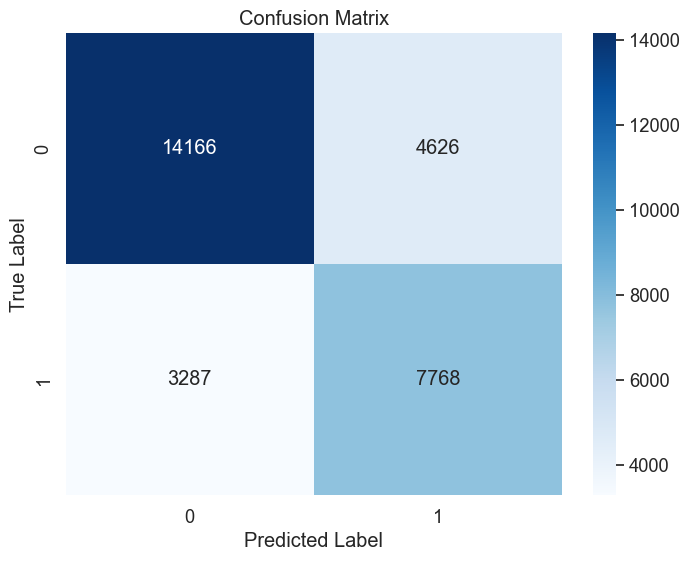

In [146]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_sigmoid_sm = BaggingClassifier(SVC(kernel='sigmoid', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_sigmoid_sm = GridSearchCV(svm_sigmoid_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_sigmoid_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_sigmoid_sm = grid_search_svm_sigmoid_sm.best_estimator_

# Make predictions
y_pred = best_svm_sigmoid_sm.predict(X_test_selected_df)


# Calculate probability For AUC
y_proba = best_svm_sigmoid_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - sigmoid')
print("Best Parameters:", grid_search_svm_sigmoid_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_sigmoid_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_sigmoid_sm.classes_, yticklabels=best_svm_sigmoid_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - RBF

SVM - rbf
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     18792
           1       0.77      0.78      0.77     11055

    accuracy                           0.83     29847
   macro avg       0.82      0.82      0.82     29847
weighted avg       0.83      0.83      0.83     29847

AUC: 0.9025572074801502


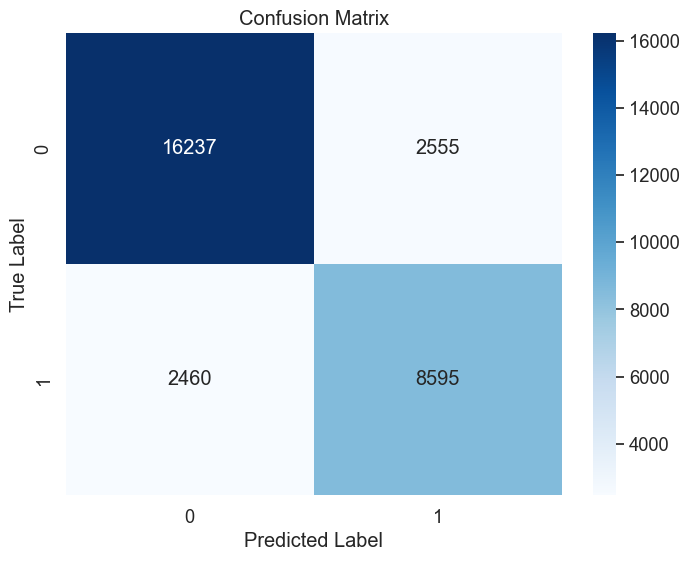

In [147]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_rbf_sm = BaggingClassifier(SVC(kernel='rbf', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_rbf_sm = GridSearchCV(svm_rbf_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_rbf_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_rbf_sm = grid_search_svm_rbf_sm.best_estimator_

# Make predictions
y_pred = best_svm_rbf_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_rbf_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - rbf')
print("Best Parameters:", grid_search_svm_rbf_sm.best_params_)
print(report)

print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_rbf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_rbf_sm.classes_, yticklabels=best_svm_rbf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Poly

SVM - poly
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     18792
           1       0.76      0.78      0.77     11055

    accuracy                           0.83     29847
   macro avg       0.82      0.82      0.82     29847
weighted avg       0.83      0.83      0.83     29847

AUC: 0.9007177746662793


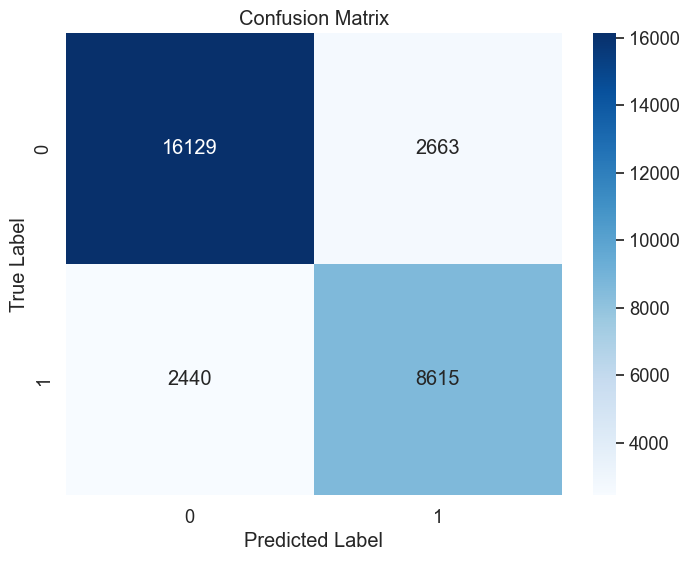

In [161]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_poly_sm = BaggingClassifier(SVC(kernel='poly', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10, random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_poly_sm = GridSearchCV(svm_poly_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_poly_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_poly_sm = grid_search_svm_poly_sm.best_estimator_

# Make predictions
y_pred = best_svm_poly_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_poly_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - poly')
print("Best Parameters:", grid_search_svm_poly_sm.best_params_)
print(report)

print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_poly_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_poly_sm.classes_, yticklabels=best_svm_poly_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RBFNN

Best number of RBF units: 5000
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     18792
           1       0.77      0.76      0.77     11055

    accuracy                           0.83     29847
   macro avg       0.82      0.82      0.82     29847
weighted avg       0.83      0.83      0.83     29847

[[16292  2500]
 [ 2614  8441]]
AUC: 0.8981770464793567


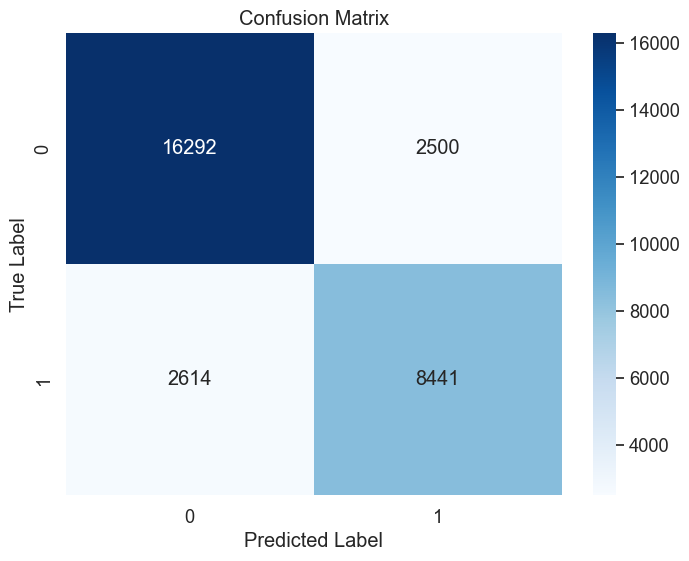

In [111]:
# Define the list of candidate values for the number of RBF units
num_of_rbf_units_list = [10, 50, 100, 300, 1000, 5000]
# Perform grid search cross-validation to find the best number of RBF units
best_num_of_rbf_units = grid_search_cv(X_resampled, y_resampled, num_of_rbf_units_list)
print("Best number of RBF units:", best_num_of_rbf_units)
rbf_neural_network_sm = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=best_num_of_rbf_units)
rbf_neural_network_sm.train_model(X_resampled.values, y_resampled.values)
# Predict the target values
predictions = rbf_neural_network_sm.predict(X_test_selected_df.values)
# Converting continuous output to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, binary_predictions))
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
print(cm)
print('AUC:',roc_auc_score(y_test,predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Stratified sampling

In [112]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_test_selected_df, y_test, test_size=0.035, stratify=y_test, random_state=42)

In [113]:
X_test_temp

hotel_City Hotel  hotel_Resort Hotel  lead_time  \
27155               1.0                 0.0  -0.502932   
17052               1.0                 0.0  -0.943045   
12671               1.0                 0.0  -0.924317   
9359                0.0                 1.0  -0.624666   
1126                0.0                 1.0  -0.287558   
...                 ...                 ...        ...   
25591               1.0                 0.0  -0.437384   
10934               1.0                 0.0  -0.933681   
21831               1.0                 0.0  -0.952409   
12642               1.0                 0.0  -0.924317   
16492               1.0                 0.0   1.510349   

       arrival_date_year_2015  arrival_date_year_2016  arrival_date_year_2017  \
27155                     0.0                     0.0                     1.0   
17052                     0.0                     0.0                     1.0   
12671                     0.0                     1.0                     0.0   
9359                      0.0                     1.0                     0.0   
1126                      0.0                     0.0                     1.0   
...                       ...                     ...                     ...   
25591                     0.0                     0.0                     1.0   
10934                     0.0                     1.0                     0.0   
21831                     0.0                     1.0                     0.0   
12642                     0.0                     0.0                     1.0   
16492                     0.0                     1.0                     0.0   

       arrival_date_month_1  arrival_date_month_2  arrival_date_month_3  \
27155                   0.0                   1.0                   0.0   
17052                   1.0                   0.0                   0.0   
12671                   0.0                   1.0                   0.0   
9359                    0.0                   0.0                   0.0   
1126                    0.0                   1.0                   0.0   
...                     ...                   ...                   ...   
25591                   0.0                   0.0                   0.0   
10934                   0.0                   0.0                   0.0   
21831                   0.0                   0.0                   0.0   
12642                   1.0                   0.0                   0.0   
16492                   0.0                   0.0                   0.0   

       arrival_date_month_4  ...  agent_241.0  company_0.0  \
27155                   0.0  ...          0.0          1.0   
17052                   0.0  ...          0.0          0.0   
12671                   0.0  ...          0.0          0.0   
9359                    0.0  ...          1.0          1.0   
1126                    0.0  ...          0.0          0.0   
...                     ...  ...          ...          ...   
25591                   1.0  ...          0.0          1.0   
10934                   0.0  ...          0.0          1.0   
21831                   1.0  ...          0.0          1.0   
12642                   0.0  ...          0.0          0.0   
16492                   1.0  ...          0.0          1.0   

       customer_type_Contract  customer_type_Transient  \
27155                     0.0                      1.0   
17052                     0.0                      1.0   
12671                     0.0                      1.0   
9359                      0.0                      1.0   
1126                      0.0                      0.0   
...                       ...                      ...   
25591                     0.0                      1.0   
10934                     0.0                      1.0   
21831                     0.0                      1.0   
12642                     0.0                      1.0   
16492                     0.0                      1.

# SHAP

## Without SMOTE

#### Dummy

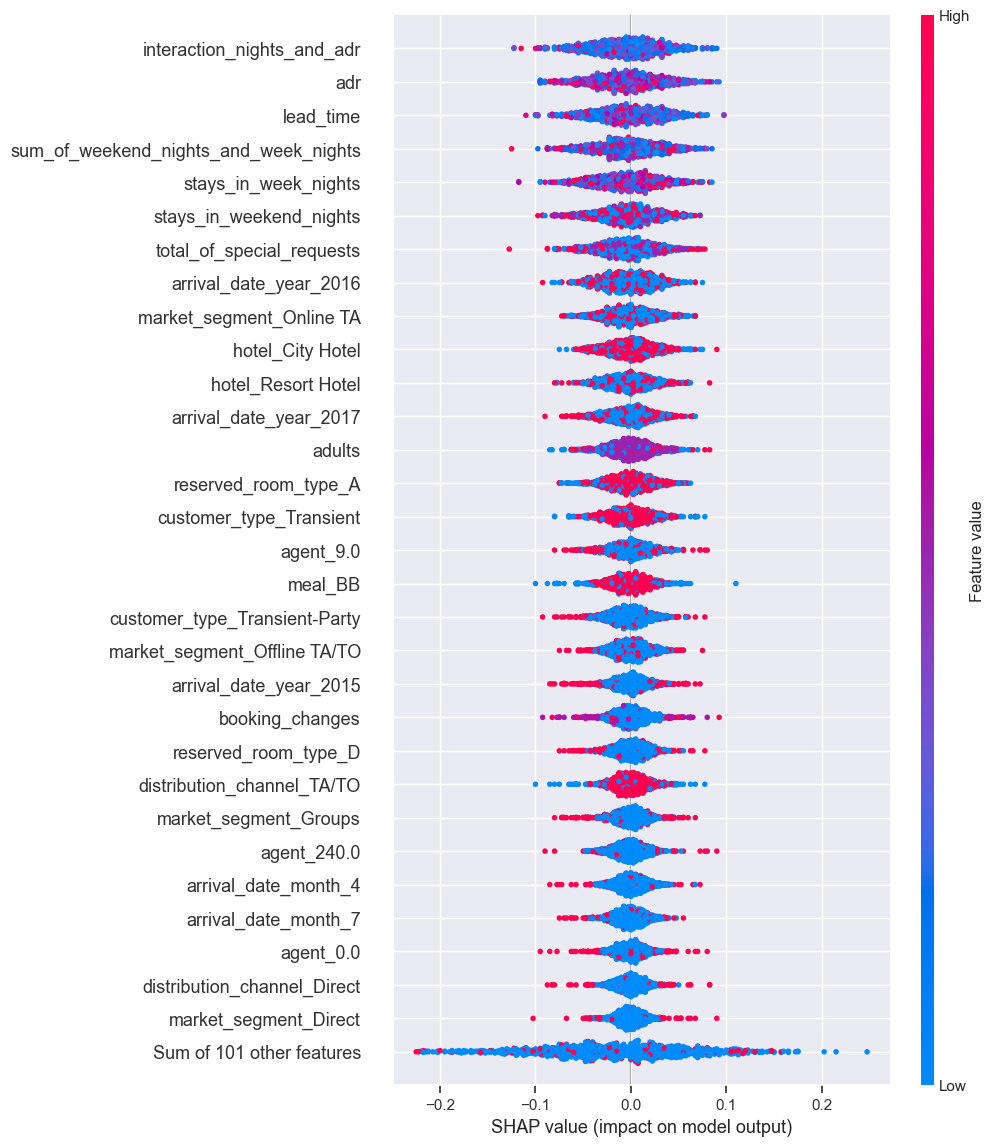

In [235]:
explainer_dc = shap.Explainer(best_dummy_clf.predict, X_train_selected_df)
shap_values_dc = explainer_dc(X_test_temp)
shap.plots.beeswarm(shap_values_dc,max_display=31)

In [214]:
# Calculate the importance
average_shap_values = np.abs(shap_values_dc.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
130             interaction_nights_and_adr         0.026703
126                                    adr         0.026562
2                                lead_time         0.026392
129  sum_of_weekend_nights_and_week_nights         0.024840
88                    stays_in_week_nights         0.024543
87                 stays_in_weekend_nights         0.022639
128              total_of_special_requests         0.021732
4                   arrival_date_year_2016         0.020545
98                market_segment_Online TA         0.018861
0                         hotel_City Hotel         0.018196
1                       hotel_Resort Hotel         0.018079
5                   arrival_date_year_2017         0.017952
89                                  adults         0.017311
106                   reserved_room_type_A         0.017237
124                customer_type_Transient         0.017043
118                              agent_9.0         0.016148
91                                 meal_BB         0.015787
125          customer_type_Transient-Party         0.015660
97            market_segment_Offline TA/TO         0.014435
3                   arrival_date_year_2015         0.014414
110                        booking_changes         0.014115
107                   reserved_room_type_D         0.013778
101             distribution_channel_TA/TO         0.013727
96                   market_segment_Groups         0.013136
120                            agent_240.0         0.012986
9                     arrival_date_month_4         0.012500
12                    arrival_date_month_7         0.012400
113                              agent_0.0         0.012321
100            distribution_channel_Direct         0.011852
95                   market_segment_Direct         0.010880

#### RF

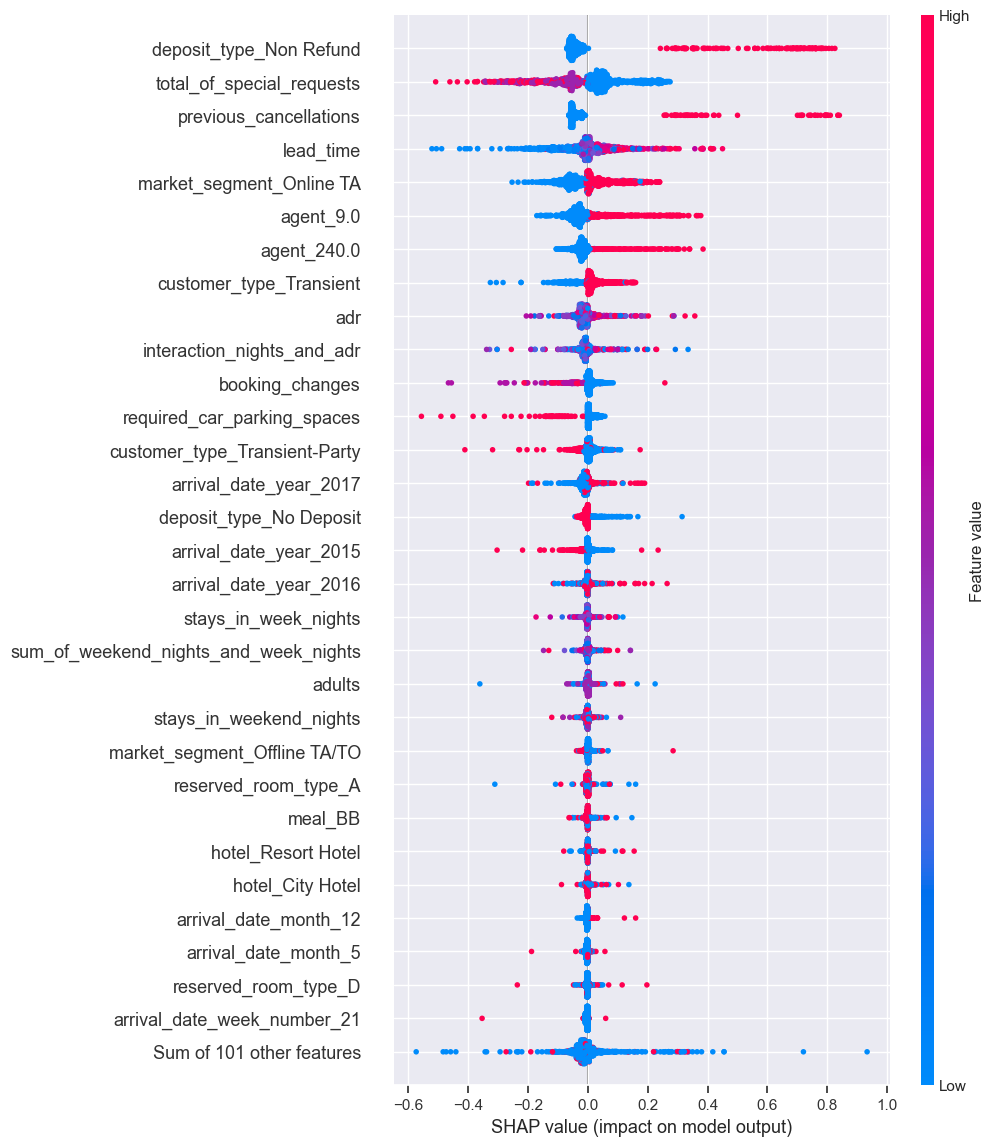

In [236]:
explainer_rf = shap.Explainer(best_rf.predict, X_train_selected_df)
shap_values_rf = explainer_rf(X_test_temp)
shap.plots.beeswarm(shap_values_rf,max_display=31)

In [215]:
# Calculate the importance
average_shap_values = np.abs(shap_values_rf.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
112                deposit_type_Non Refund         0.114115
128              total_of_special_requests         0.095000
104                 previous_cancellations         0.070574
2                                lead_time         0.065189
98                market_segment_Online TA         0.058330
118                              agent_9.0         0.058306
120                            agent_240.0         0.033897
124                customer_type_Transient         0.033715
126                                    adr         0.026392
130             interaction_nights_and_adr         0.020108
110                        booking_changes         0.019510
127            required_car_parking_spaces         0.017928
125          customer_type_Transient-Party         0.016467
5                   arrival_date_year_2017         0.016344
111                deposit_type_No Deposit         0.010244
3                   arrival_date_year_2015         0.010069
4                   arrival_date_year_2016         0.009373
88                    stays_in_week_nights         0.006361
129  sum_of_weekend_nights_and_week_nights         0.005897
89                                  adults         0.005010
87                 stays_in_weekend_nights         0.004978
97            market_segment_Offline TA/TO         0.004696
106                   reserved_room_type_A         0.004029
91                                 meal_BB         0.004019
1                       hotel_Resort Hotel         0.003754
0                         hotel_City Hotel         0.003533
17                   arrival_date_month_12         0.003443
10                    arrival_date_month_5         0.003378
107                   reserved_room_type_D         0.003280
62             arrival_date_week_number_21         0.003005

#### SVME - Linear

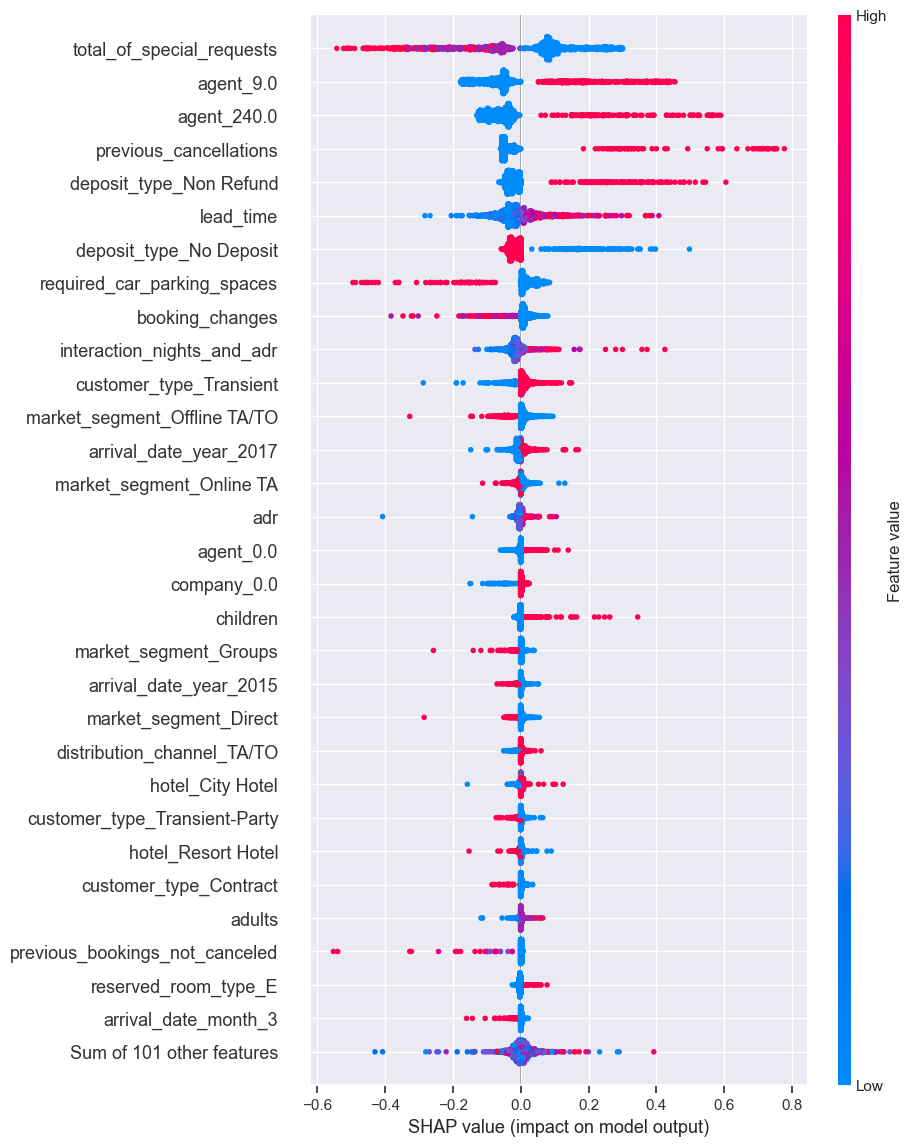

In [237]:
explainer_svm_linear = shap.Explainer(best_svm_linear.predict, X_train_selected_df)
shap_values_svm_linear = explainer_svm_linear(X_test_temp)
shap.plots.beeswarm(shap_values_svm_linear,max_display=31)

In [216]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_linear.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128       total_of_special_requests         0.145158
118                       agent_9.0         0.124156
120                     agent_240.0         0.092981
104          previous_cancellations         0.064433
112         deposit_type_Non Refund         0.059182
2                         lead_time         0.048801
111         deposit_type_No Deposit         0.042428
127     required_car_parking_spaces         0.033577
110                 booking_changes         0.023696
130      interaction_nights_and_adr         0.022892
124         customer_type_Transient         0.019541
97     market_segment_Offline TA/TO         0.018079
5            arrival_date_year_2017         0.012435
98         market_segment_Online TA         0.009919
126                             adr         0.007328
113                       agent_0.0         0.007275
122                     company_0.0         0.006189
90                         children         0.006141
96            market_segment_Groups         0.005421
3            arrival_date_year_2015         0.005079
95            market_segment_Direct         0.004737
101      distribution_channel_TA/TO         0.004639
0                  hotel_City Hotel         0.004610
125   customer_type_Transient-Party         0.004404
1                hotel_Resort Hotel         0.004268
123          customer_type_Contract         0.004201
89                           adults         0.004086
105  previous_bookings_not_canceled         0.004005
108            reserved_room_type_E         0.003785
8              arrival_date_month_3         0.003703

#### SVME - Sigmoid

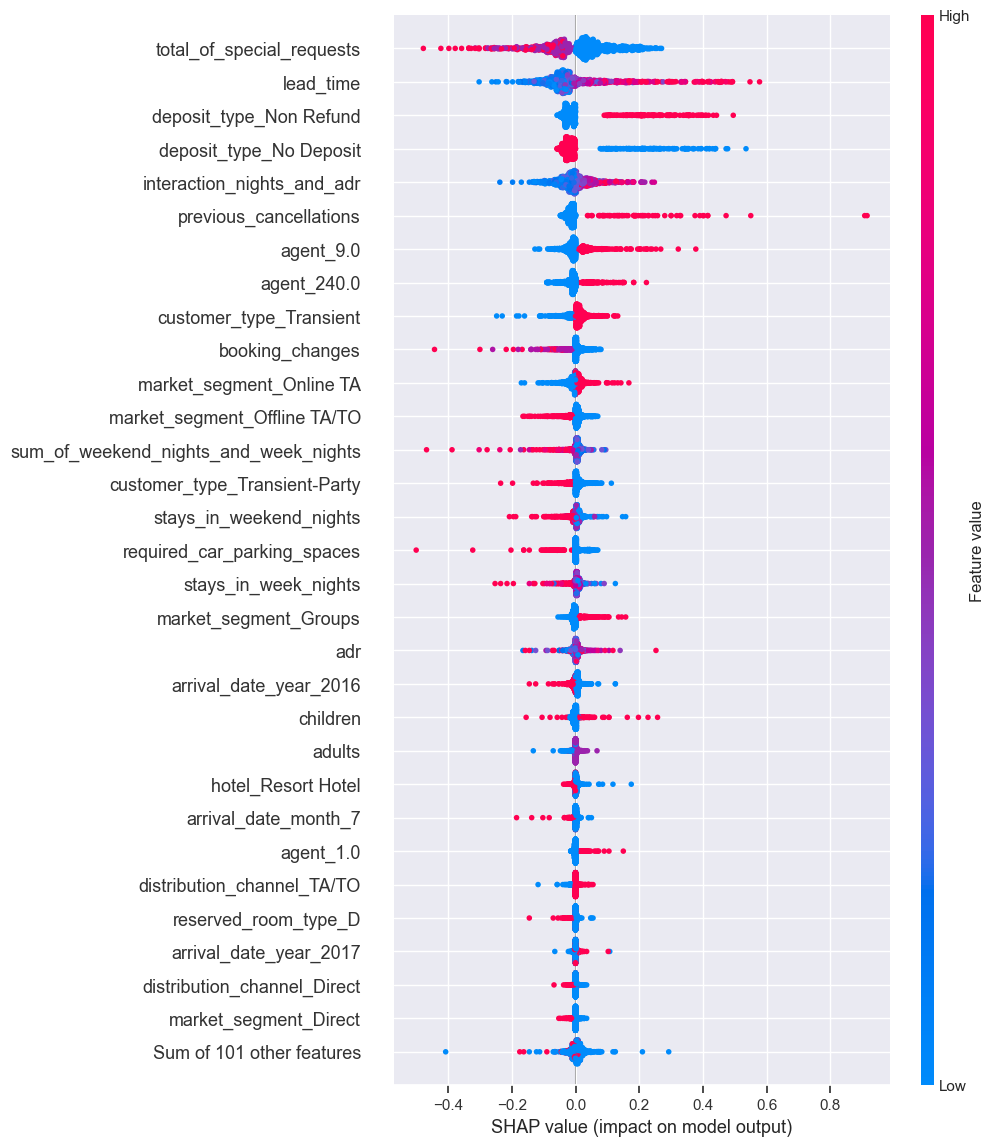

In [238]:
explainer_svm_sigmoid = shap.Explainer(best_svm_sigmoid.predict, X_train_selected_df)
shap_values_svm_sigmoid = explainer_svm_sigmoid(X_test_temp)
shap.plots.beeswarm(shap_values_svm_sigmoid,max_display=31)

In [217]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_sigmoid.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.082007
2                                lead_time         0.080160
112                deposit_type_Non Refund         0.048656
111                deposit_type_No Deposit         0.048450
130             interaction_nights_and_adr         0.037921
104                 previous_cancellations         0.027218
118                              agent_9.0         0.025612
120                            agent_240.0         0.019459
124                customer_type_Transient         0.019033
110                        booking_changes         0.016945
98                market_segment_Online TA         0.014957
97            market_segment_Offline TA/TO         0.013825
129  sum_of_weekend_nights_and_week_nights         0.013665
125          customer_type_Transient-Party         0.013050
87                 stays_in_weekend_nights         0.011928
127            required_car_parking_spaces         0.011687
88                    stays_in_week_nights         0.010612
96                   market_segment_Groups         0.009878
126                                    adr         0.009435
4                   arrival_date_year_2016         0.008115
90                                children         0.005897
89                                  adults         0.004146
1                       hotel_Resort Hotel         0.004136
12                    arrival_date_month_7         0.003541
114                              agent_1.0         0.003323
101             distribution_channel_TA/TO         0.003179
107                   reserved_room_type_D         0.002833
5                   arrival_date_year_2017         0.002667
100            distribution_channel_Direct         0.002526
95                   market_segment_Direct         0.002445

#### SVME - RBF

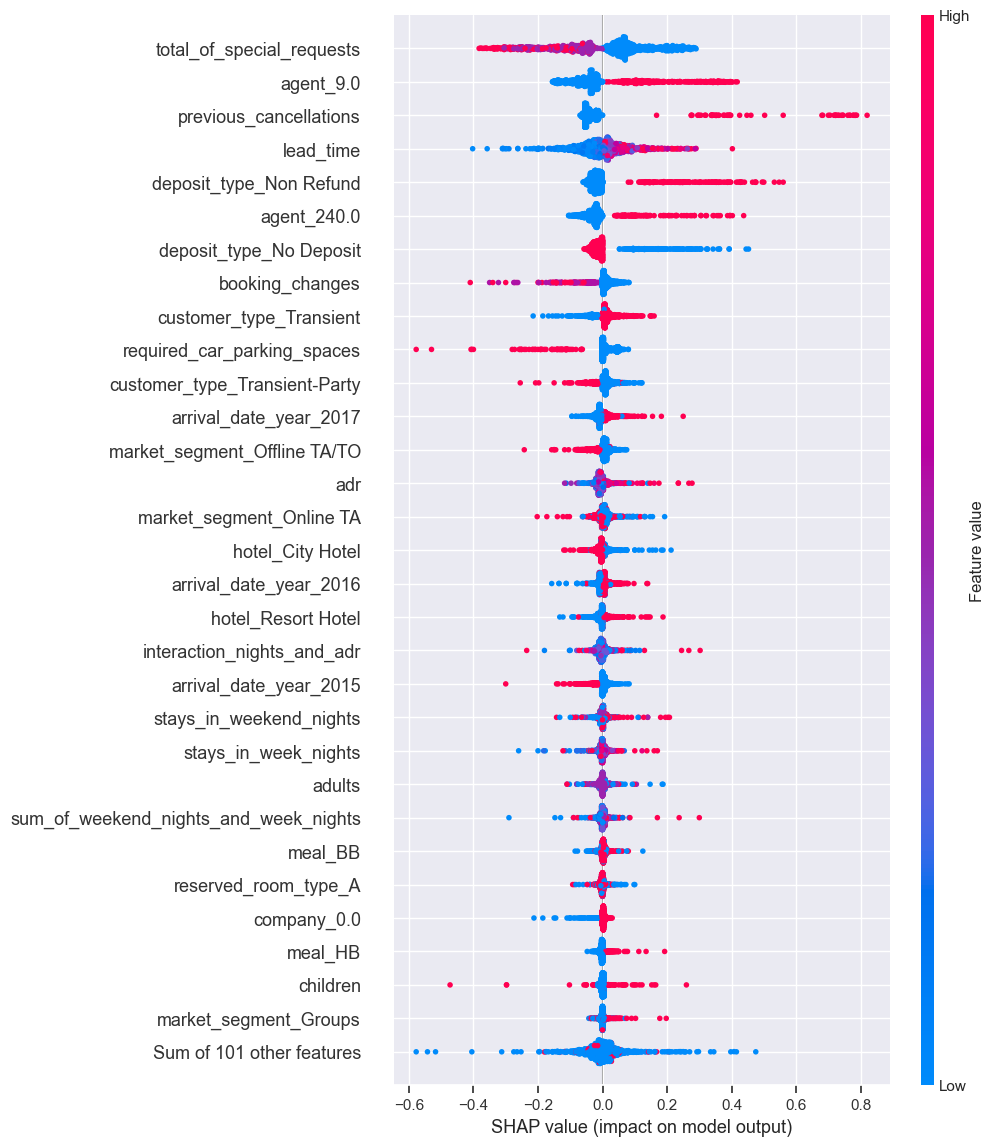

In [239]:
explainer_svm_rbf = shap.Explainer(best_svm_rbf.predict, X_train_selected_df)
shap_values_svm_rbf = explainer_svm_rbf(X_test_temp)
shap.plots.beeswarm(shap_values_svm_rbf,max_display=31)

In [218]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_rbf.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.120840
118                              agent_9.0         0.091708
104                 previous_cancellations         0.068610
2                                lead_time         0.058110
112                deposit_type_Non Refund         0.052718
120                            agent_240.0         0.043766
111                deposit_type_No Deposit         0.038593
110                        booking_changes         0.027103
124                customer_type_Transient         0.025476
127            required_car_parking_spaces         0.024624
125          customer_type_Transient-Party         0.019378
5                   arrival_date_year_2017         0.015545
97            market_segment_Offline TA/TO         0.015041
126                                    adr         0.014921
98                market_segment_Online TA         0.014730
0                         hotel_City Hotel         0.012380
4                   arrival_date_year_2016         0.011560
1                       hotel_Resort Hotel         0.011548
130             interaction_nights_and_adr         0.011543
3                   arrival_date_year_2015         0.011529
87                 stays_in_weekend_nights         0.010151
88                    stays_in_week_nights         0.009639
89                                  adults         0.008797
129  sum_of_weekend_nights_and_week_nights         0.008122
91                                 meal_BB         0.007117
106                   reserved_room_type_A         0.006435
122                            company_0.0         0.006342
92                                 meal_HB         0.006258
90                                children         0.006100
96                   market_segment_Groups         0.005871

#### SVME - Poly

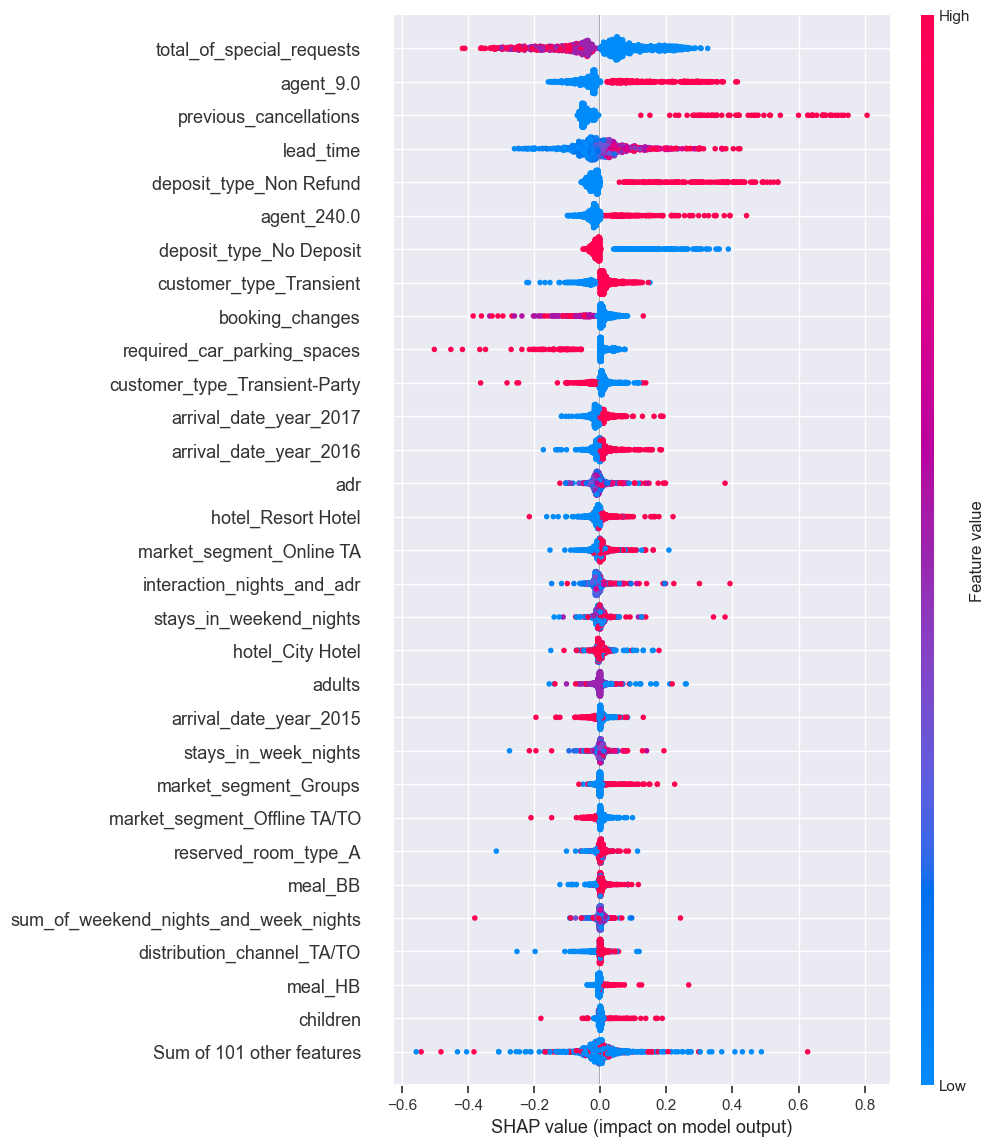

In [240]:
explainer_svm_poly = shap.Explainer(best_svm_poly.predict, X_train_selected_df)
shap_values_svm_poly = explainer_svm_poly(X_test_temp)
shap.plots.beeswarm(shap_values_svm_poly,max_display=31)

In [219]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_poly.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.108644
118                              agent_9.0         0.071189
104                 previous_cancellations         0.066663
2                                lead_time         0.058629
112                deposit_type_Non Refund         0.053340
120                            agent_240.0         0.034110
111                deposit_type_No Deposit         0.033476
124                customer_type_Transient         0.026091
110                        booking_changes         0.023885
127            required_car_parking_spaces         0.020172
125          customer_type_Transient-Party         0.017890
5                   arrival_date_year_2017         0.017366
4                   arrival_date_year_2016         0.016349
126                                    adr         0.015952
1                       hotel_Resort Hotel         0.015864
98                market_segment_Online TA         0.014957
130             interaction_nights_and_adr         0.014120
87                 stays_in_weekend_nights         0.010914
0                         hotel_City Hotel         0.010589
89                                  adults         0.010517
3                   arrival_date_year_2015         0.009624
88                    stays_in_week_nights         0.009170
96                   market_segment_Groups         0.009108
97            market_segment_Offline TA/TO         0.009029
106                   reserved_room_type_A         0.008187
91                                 meal_BB         0.008093
129  sum_of_weekend_nights_and_week_nights         0.007266
101             distribution_channel_TA/TO         0.006644
92                                 meal_HB         0.005976
90                                children         0.005411

#### RBFNN

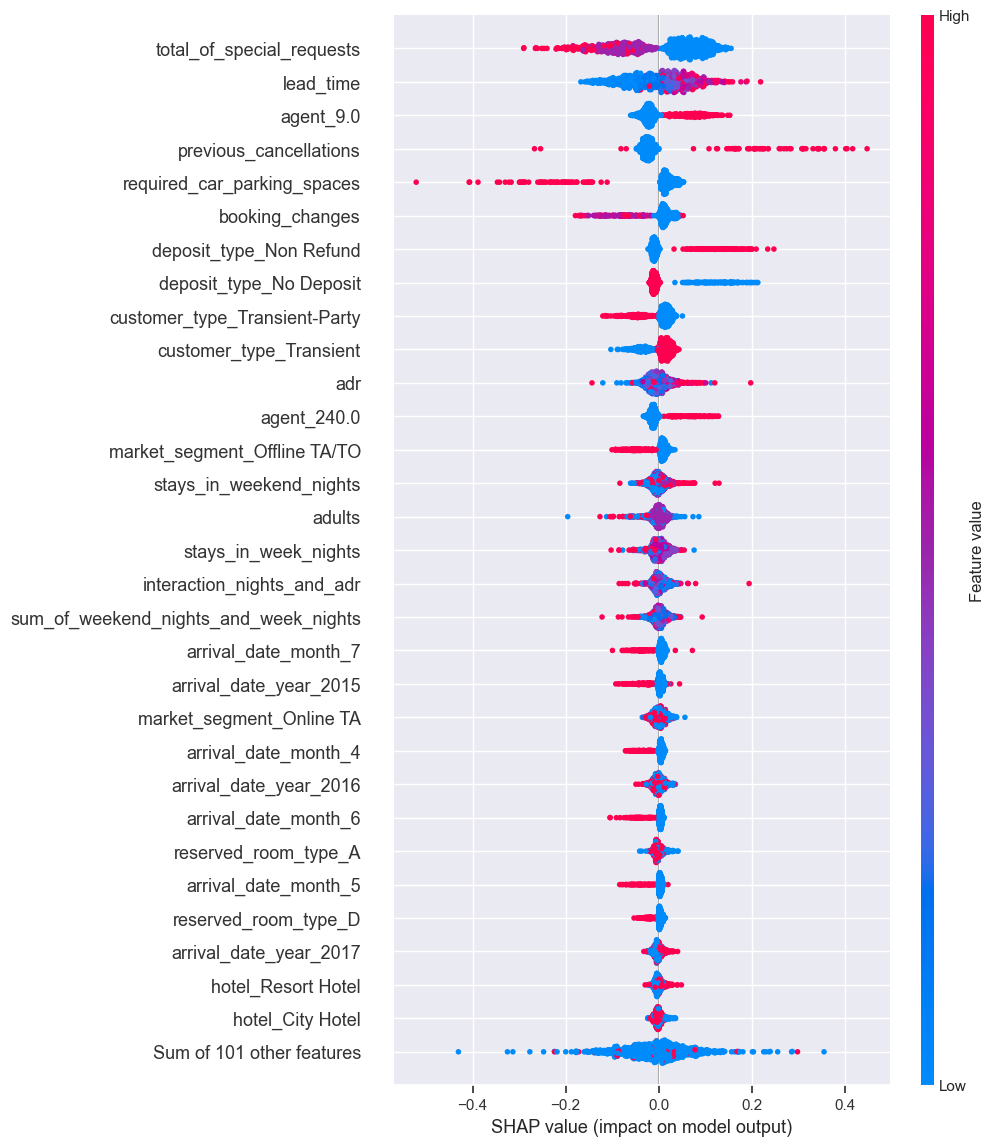

In [241]:
explainer_rbfnn = shap.Explainer(rbf_neural_network.predict, X_train_selected_df.values)
shap_values_rbfnn = explainer_rbfnn(X_test_temp)
shap.plots.beeswarm(shap_values_rbfnn,max_display=31)

In [220]:
# Calculate the importance
average_shap_values = np.abs(shap_values_rbfnn.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.081649
2                                lead_time         0.052184
118                              agent_9.0         0.036538
104                 previous_cancellations         0.036317
127            required_car_parking_spaces         0.033711
110                        booking_changes         0.026819
112                deposit_type_Non Refund         0.024920
111                deposit_type_No Deposit         0.024457
125          customer_type_Transient-Party         0.022659
124                customer_type_Transient         0.021702
126                                    adr         0.018546
120                            agent_240.0         0.018455
97            market_segment_Offline TA/TO         0.017605
87                 stays_in_weekend_nights         0.012844
89                                  adults         0.012525
88                    stays_in_week_nights         0.012370
130             interaction_nights_and_adr         0.011327
129  sum_of_weekend_nights_and_week_nights         0.010861
12                    arrival_date_month_7         0.010368
3                   arrival_date_year_2015         0.010225
98                market_segment_Online TA         0.009948
9                     arrival_date_month_4         0.008900
4                   arrival_date_year_2016         0.008766
11                    arrival_date_month_6         0.007428
106                   reserved_room_type_A         0.007140
10                    arrival_date_month_5         0.006942
107                   reserved_room_type_D         0.006645
5                   arrival_date_year_2017         0.006635
1                       hotel_Resort Hotel         0.006209
0                         hotel_City Hotel         0.006073

## With SMOTE

#### Dummy

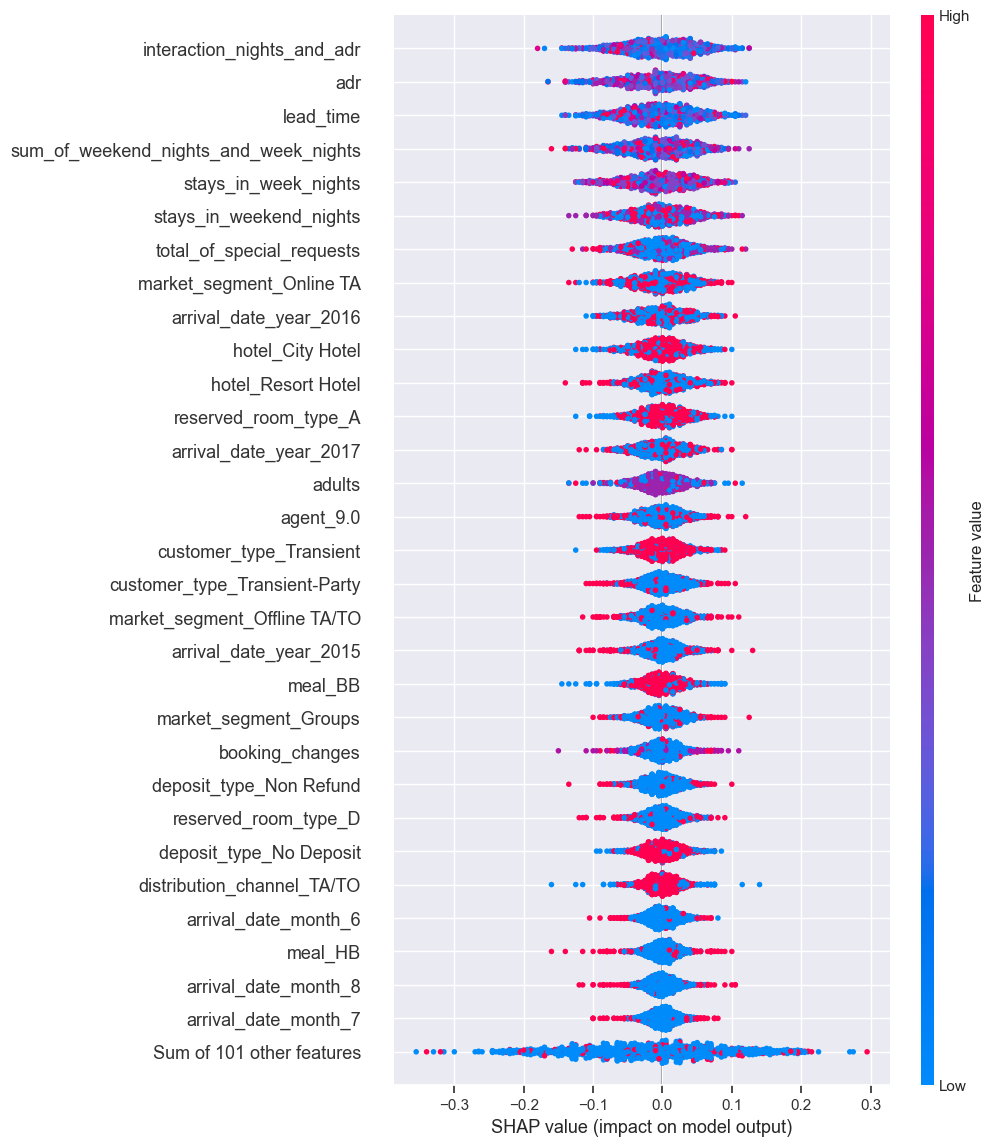

In [228]:
explainer_dc_sm = shap.Explainer(best_dummy_clf_sm.predict, X_resampled)
shap_values_dc_sm = explainer_dc_sm(X_test_temp)
shap.plots.beeswarm(shap_values_dc_sm,max_display=31)

In [221]:
# Calculate the importance
average_shap_values = np.abs(shap_values_dc_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
130             interaction_nights_and_adr         0.038498
126                                    adr         0.038416
2                                lead_time         0.037163
129  sum_of_weekend_nights_and_week_nights         0.036522
88                    stays_in_week_nights         0.034507
87                 stays_in_weekend_nights         0.031292
128              total_of_special_requests         0.029053
98                market_segment_Online TA         0.028579
4                   arrival_date_year_2016         0.028062
0                         hotel_City Hotel         0.025569
1                       hotel_Resort Hotel         0.025545
106                   reserved_room_type_A         0.024742
5                   arrival_date_year_2017         0.024411
89                                  adults         0.024110
118                              agent_9.0         0.023660
124                customer_type_Transient         0.022407
125          customer_type_Transient-Party         0.022196
97            market_segment_Offline TA/TO         0.022057
3                   arrival_date_year_2015         0.021579
91                                 meal_BB         0.021373
96                   market_segment_Groups         0.020990
110                        booking_changes         0.019866
112                deposit_type_Non Refund         0.019770
107                   reserved_room_type_D         0.019440
111                deposit_type_No Deposit         0.019325
101             distribution_channel_TA/TO         0.018072
11                    arrival_date_month_6         0.017297
92                                 meal_HB         0.016684
13                    arrival_date_month_8         0.016622
12                    arrival_date_month_7         0.016139

#### RF

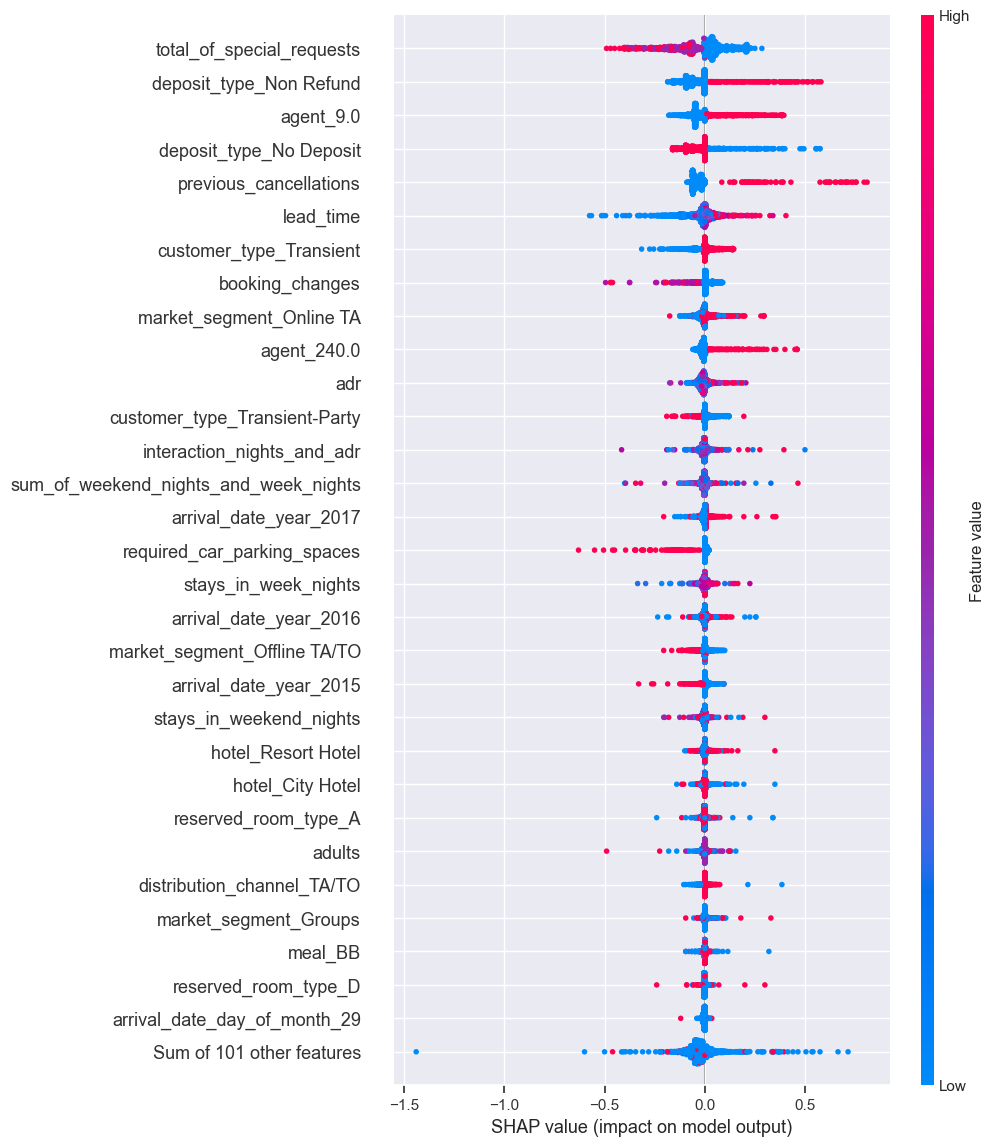

In [229]:
explainer_rf_sm = shap.Explainer(best_rf_sm.predict,X_resampled)
shap_values_rf_sm = explainer_rf_sm(X_test_temp)
shap.plots.beeswarm(shap_values_rf_sm,max_display=31)

In [222]:
# Calculate the importance
average_shap_values = np.abs(shap_values_rf_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.099416
112                deposit_type_Non Refund         0.080043
118                              agent_9.0         0.064708
111                deposit_type_No Deposit         0.062742
104                 previous_cancellations         0.060703
2                                lead_time         0.055646
124                customer_type_Transient         0.034670
110                        booking_changes         0.026244
98                market_segment_Online TA         0.025005
120                            agent_240.0         0.024727
126                                    adr         0.019756
125          customer_type_Transient-Party         0.017689
130             interaction_nights_and_adr         0.015502
129  sum_of_weekend_nights_and_week_nights         0.014311
5                   arrival_date_year_2017         0.013938
127            required_car_parking_spaces         0.013746
88                    stays_in_week_nights         0.012220
4                   arrival_date_year_2016         0.011933
97            market_segment_Offline TA/TO         0.011880
3                   arrival_date_year_2015         0.011761
87                 stays_in_weekend_nights         0.009359
1                       hotel_Resort Hotel         0.008990
0                         hotel_City Hotel         0.008880
106                   reserved_room_type_A         0.008431
89                                  adults         0.007297
101             distribution_channel_TA/TO         0.006809
96                   market_segment_Groups         0.006656
91                                 meal_BB         0.005522
107                   reserved_room_type_D         0.004923
46            arrival_date_day_of_month_29         0.004330

#### SVME - Linear

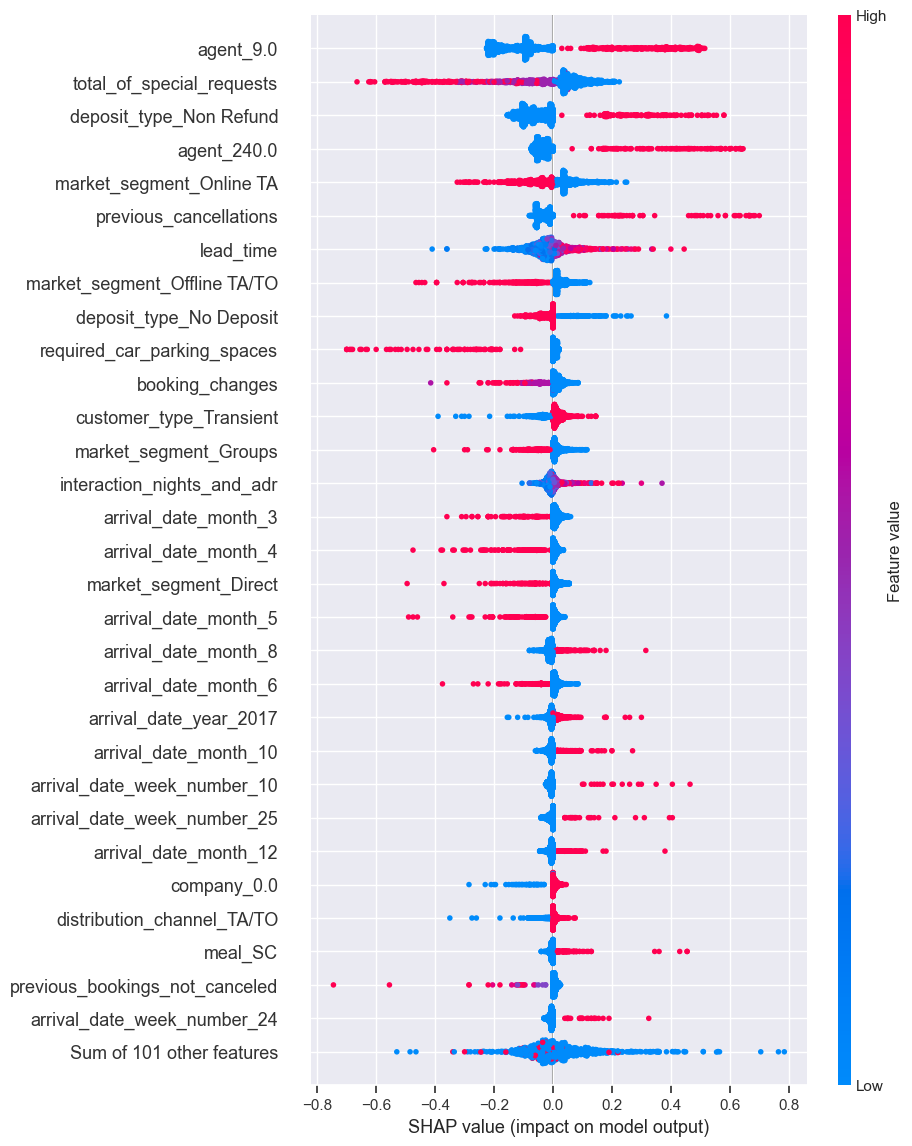

In [230]:
explainer_svm_linear_sm = shap.Explainer(best_svm_linear_sm.predict, X_resampled)
shap_values_svm_linear_sm = explainer_svm_linear_sm(X_test_temp)
shap.plots.beeswarm(shap_values_svm_linear_sm,max_display=31)

In [223]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_linear_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
118                       agent_9.0         0.182215
128       total_of_special_requests         0.118923
112         deposit_type_Non Refund         0.095182
120                     agent_240.0         0.077612
98         market_segment_Online TA         0.061440
104          previous_cancellations         0.053378
2                         lead_time         0.051402
97     market_segment_Offline TA/TO         0.044182
111         deposit_type_No Deposit         0.032297
127     required_car_parking_spaces         0.027110
110                 booking_changes         0.025828
124         customer_type_Transient         0.024455
96            market_segment_Groups         0.022923
130      interaction_nights_and_adr         0.019000
8              arrival_date_month_3         0.018722
9              arrival_date_month_4         0.017923
95            market_segment_Direct         0.016861
10             arrival_date_month_5         0.016483
13             arrival_date_month_8         0.016182
11             arrival_date_month_6         0.014947
5            arrival_date_year_2017         0.014325
15            arrival_date_month_10         0.014249
51      arrival_date_week_number_10         0.011258
66      arrival_date_week_number_25         0.010464
17            arrival_date_month_12         0.010392
122                     company_0.0         0.010038
101      distribution_channel_TA/TO         0.009579
93                          meal_SC         0.009373
105  previous_bookings_not_canceled         0.009033
65      arrival_date_week_number_24         0.009014

#### SVME - Sigmoid

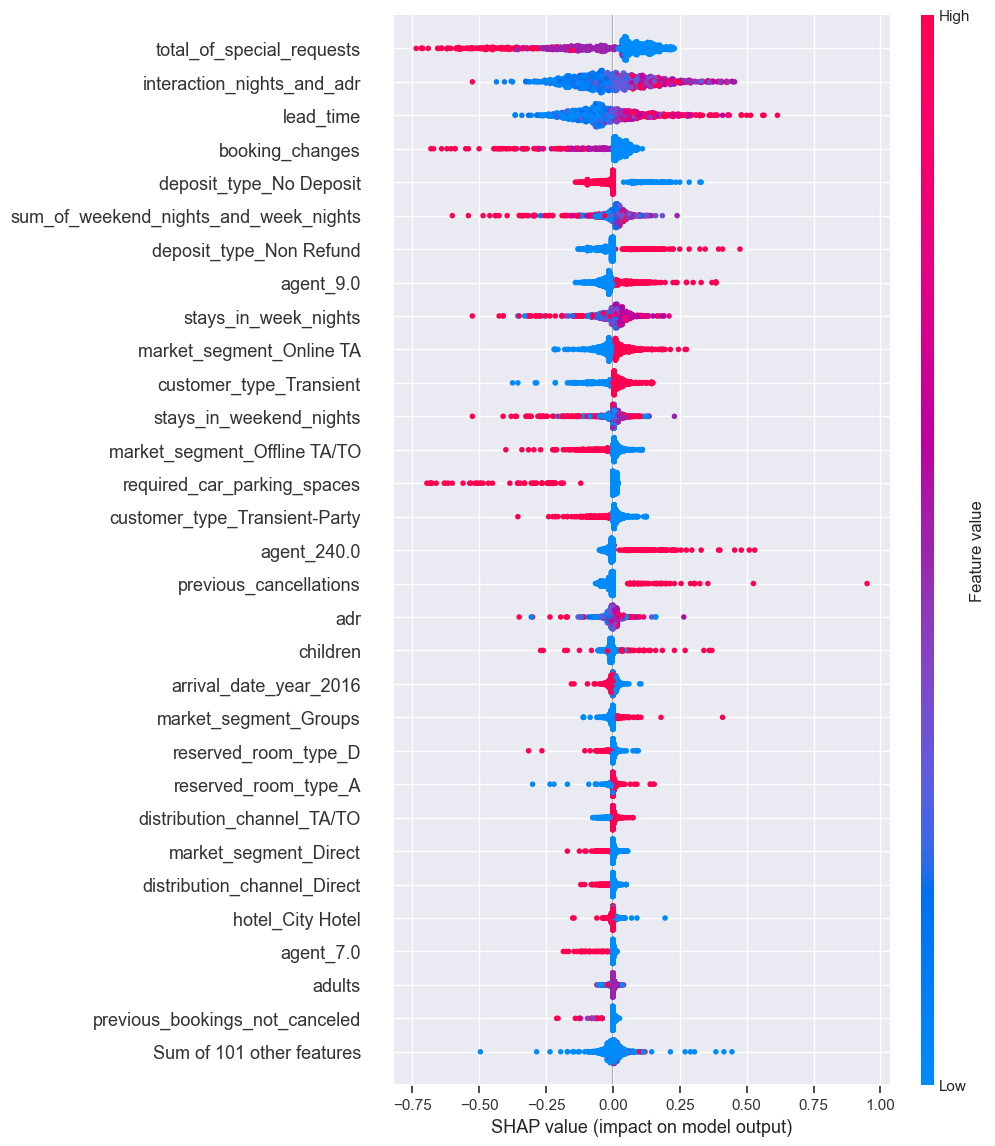

In [231]:
explainer_svm_sigmoid_sm = shap.Explainer(best_svm_sigmoid_sm.predict, X_resampled)
shap_values_svm_sigmoid_sm = explainer_svm_sigmoid_sm(X_test_temp)
shap.plots.beeswarm(shap_values_svm_sigmoid_sm,max_display=31)

In [224]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_sigmoid_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.150933
130             interaction_nights_and_adr         0.112426
2                                lead_time         0.099077
110                        booking_changes         0.054876
111                deposit_type_No Deposit         0.042134
129  sum_of_weekend_nights_and_week_nights         0.040923
112                deposit_type_Non Refund         0.040225
118                              agent_9.0         0.040201
88                    stays_in_week_nights         0.039560
98                market_segment_Online TA         0.035187
124                customer_type_Transient         0.034110
87                 stays_in_weekend_nights         0.029919
97            market_segment_Offline TA/TO         0.026794
127            required_car_parking_spaces         0.026713
125          customer_type_Transient-Party         0.025086
120                            agent_240.0         0.023426
104                 previous_cancellations         0.022727
126                                    adr         0.016215
90                                children         0.014646
4                   arrival_date_year_2016         0.010297
96                   market_segment_Groups         0.009900
107                   reserved_room_type_D         0.007220
106                   reserved_room_type_A         0.007177
101             distribution_channel_TA/TO         0.006766
95                   market_segment_Direct         0.006713
100            distribution_channel_Direct         0.006512
0                         hotel_City Hotel         0.005914
116                              agent_7.0         0.005311
89                                  adults         0.005048
105         previous_bookings_not_canceled         0.004885

#### SVME - RBF

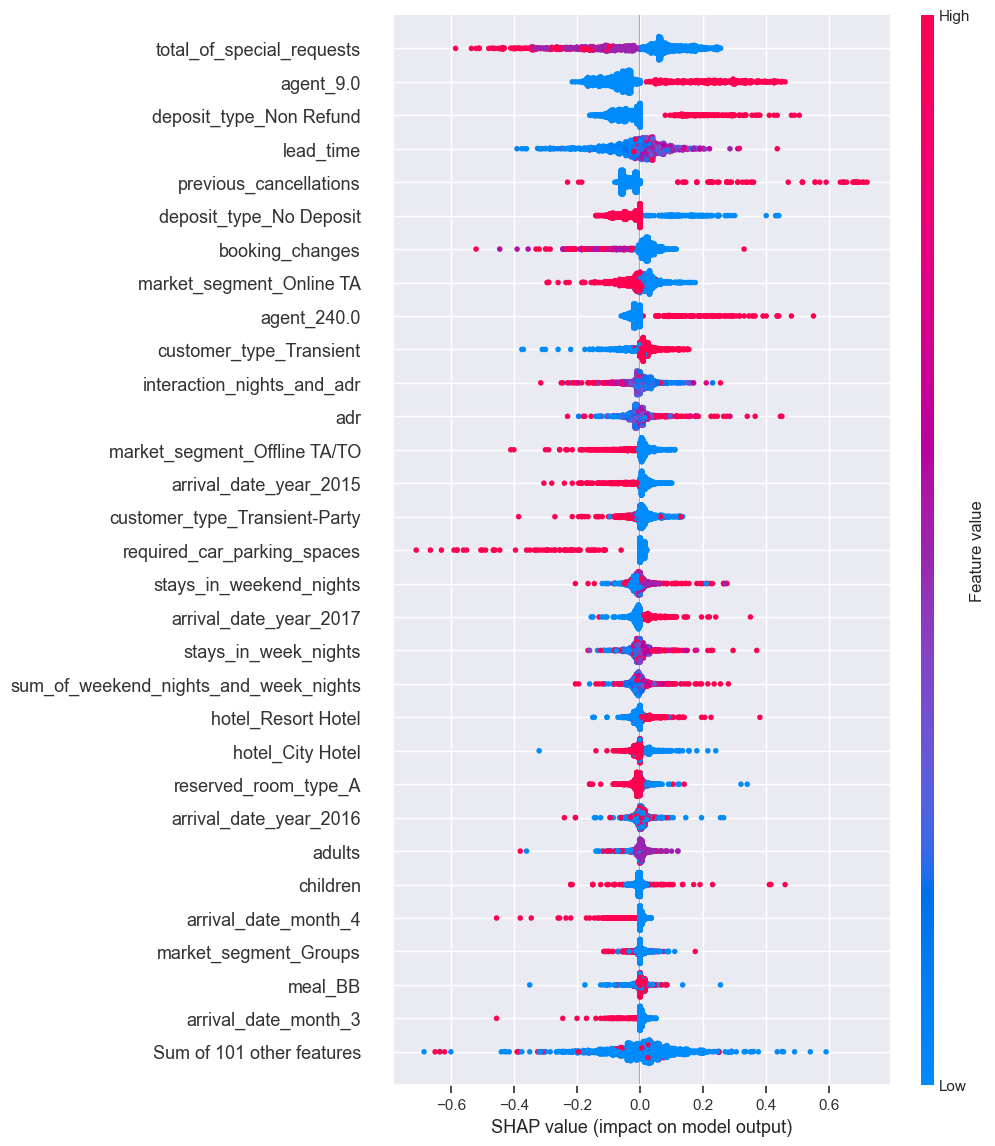

In [232]:
explainer_svm_rbf_sm = shap.Explainer(best_svm_rbf_sm.predict, X_resampled)
shap_values_svm_rbf_sm = explainer_svm_rbf_sm(X_test_temp)
shap.plots.beeswarm(shap_values_svm_rbf_sm,max_display=31)

In [225]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_rbf_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.126502
118                              agent_9.0         0.120684
112                deposit_type_Non Refund         0.067933
2                                lead_time         0.061842
104                 previous_cancellations         0.056263
111                deposit_type_No Deposit         0.049344
110                        booking_changes         0.042048
98                market_segment_Online TA         0.035153
120                            agent_240.0         0.034225
124                customer_type_Transient         0.029928
130             interaction_nights_and_adr         0.027703
126                                    adr         0.026967
97            market_segment_Offline TA/TO         0.025364
3                   arrival_date_year_2015         0.025096
125          customer_type_Transient-Party         0.024373
127            required_car_parking_spaces         0.022923
87                 stays_in_weekend_nights         0.021273
5                   arrival_date_year_2017         0.020230
88                    stays_in_week_nights         0.019531
129  sum_of_weekend_nights_and_week_nights         0.019096
1                       hotel_Resort Hotel         0.016971
0                         hotel_City Hotel         0.016895
106                   reserved_room_type_A         0.014636
4                   arrival_date_year_2016         0.014344
89                                  adults         0.014110
90                                children         0.011789
9                     arrival_date_month_4         0.010861
96                   market_segment_Groups         0.010632
91                                 meal_BB         0.010555
8                     arrival_date_month_3         0.010158

#### SVME - Poly

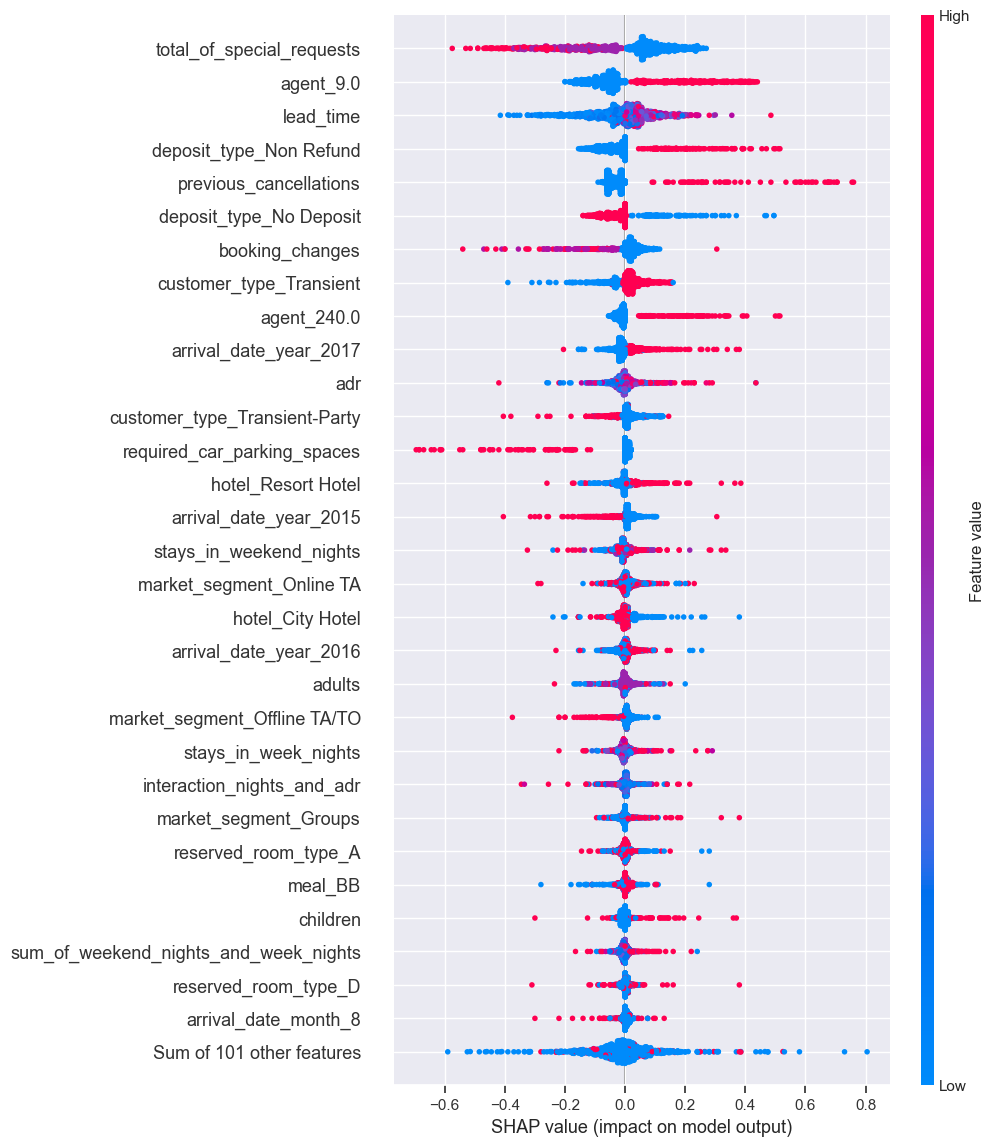

In [233]:
explainer_svm_poly_sm = shap.Explainer(best_svm_poly_sm.predict, X_resampled)
shap_values_svm_poly_sm = explainer_svm_poly_sm(X_test_temp)
shap.plots.beeswarm(shap_values_svm_poly_sm,max_display=31)

In [226]:
# Calculate the importance
average_shap_values = np.abs(shap_values_svm_poly_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.136163
118                              agent_9.0         0.111005
2                                lead_time         0.074258
112                deposit_type_Non Refund         0.062029
104                 previous_cancellations         0.055770
111                deposit_type_No Deposit         0.047239
110                        booking_changes         0.041522
124                customer_type_Transient         0.035943
120                            agent_240.0         0.031660
5                   arrival_date_year_2017         0.027670
126                                    adr         0.027641
125          customer_type_Transient-Party         0.025914
127            required_car_parking_spaces         0.024866
1                       hotel_Resort Hotel         0.024225
3                   arrival_date_year_2015         0.023335
87                 stays_in_weekend_nights         0.021636
98                market_segment_Online TA         0.019383
0                         hotel_City Hotel         0.018684
4                   arrival_date_year_2016         0.017230
89                                  adults         0.017067
97            market_segment_Offline TA/TO         0.015737
88                    stays_in_week_nights         0.015679
130             interaction_nights_and_adr         0.015043
96                   market_segment_Groups         0.013254
106                   reserved_room_type_A         0.012766
91                                 meal_BB         0.011890
90                                children         0.011804
129  sum_of_weekend_nights_and_week_nights         0.011545
107                   reserved_room_type_D         0.009416
13                    arrival_date_month_8         0.008962

#### RBFNN

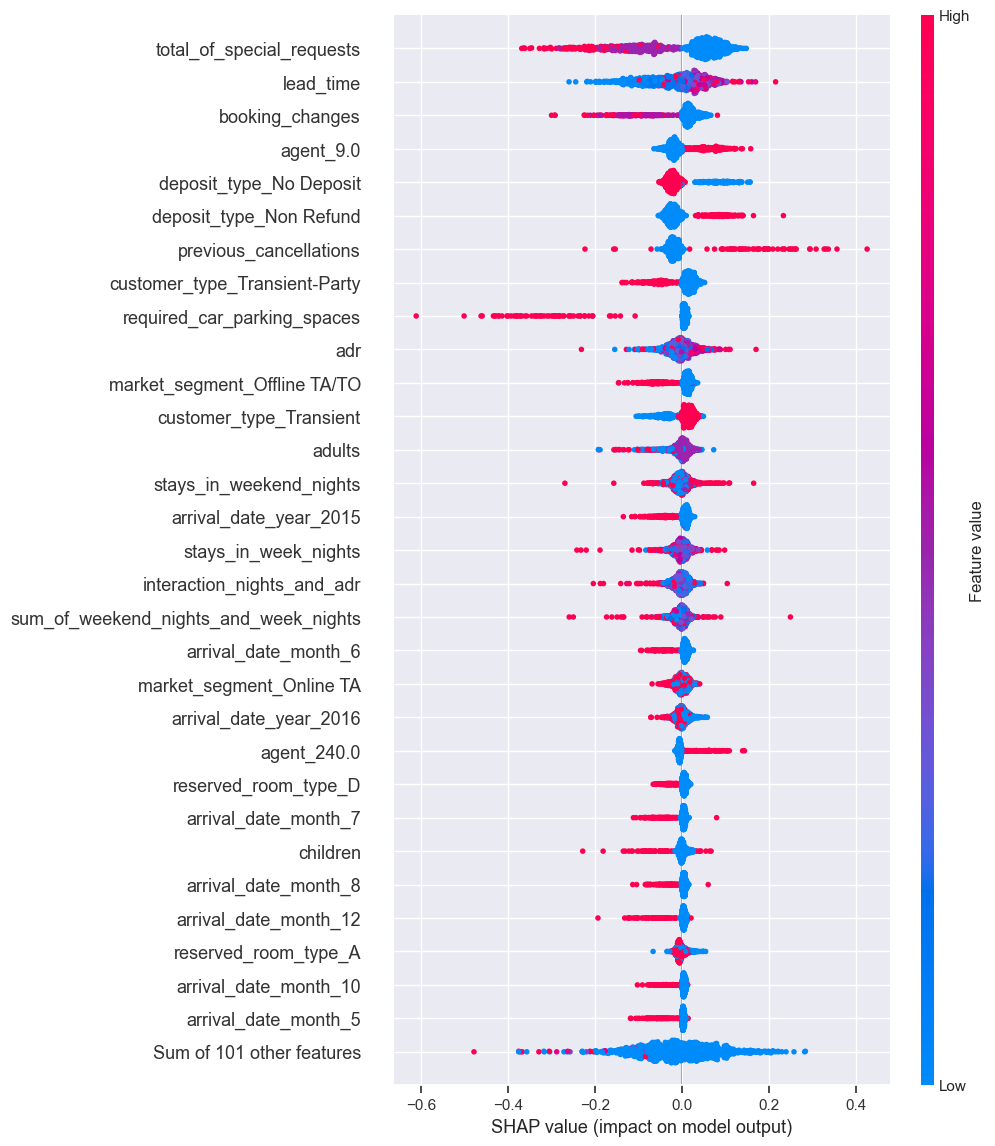

In [234]:
explainer_rbfnn_sm = shap.Explainer(rbf_neural_network_sm.predict, X_resampled.values)
shap_values_rbfnn_sm = explainer_rbfnn_sm(X_test_temp)
shap.plots.beeswarm(shap_values_rbfnn_sm,max_display=31)

In [227]:
# Calculate the importance
average_shap_values = np.abs(shap_values_rbfnn_sm.values).mean(axis=0)

# Create a DataFrame with feature names and average SHAP values
shap_df = pd.DataFrame({'Feature': X_train_selected_df.columns, 'SHAP Importance': average_shap_values})
shap_df.sort_values(by='SHAP Importance', ascending=False)[:30]

Feature  SHAP Importance
128              total_of_special_requests         0.091256
2                                lead_time         0.053138
110                        booking_changes         0.035162
118                              agent_9.0         0.030819
111                deposit_type_No Deposit         0.030131
112                deposit_type_Non Refund         0.029826
104                 previous_cancellations         0.027969
125          customer_type_Transient-Party         0.025719
127            required_car_parking_spaces         0.025592
126                                    adr         0.022193
97            market_segment_Offline TA/TO         0.022075
124                customer_type_Transient         0.021983
89                                  adults         0.017047
87                 stays_in_weekend_nights         0.016164
3                   arrival_date_year_2015         0.015587
88                    stays_in_week_nights         0.014723
130             interaction_nights_and_adr         0.014480
129  sum_of_weekend_nights_and_week_nights         0.013496
11                    arrival_date_month_6         0.012010
98                market_segment_Online TA         0.011427
4                   arrival_date_year_2016         0.010524
120                            agent_240.0         0.010407
107                   reserved_room_type_D         0.009724
12                    arrival_date_month_7         0.009620
90                                children         0.009219
13                    arrival_date_month_8         0.008811
17                   arrival_date_month_12         0.008458
106                   reserved_room_type_A         0.008452
15                   arrival_date_month_10         0.008311
10                    arrival_date_month_5         0.007954